In [1]:
!python -V

Python 3.9.2


In [2]:
# Import modules
import pandas as pd
import numpy as np
from func_utils import load_dtypes
import matplotlib.pyplot as plt
import seaborn as sns
import random
import missingno as msno
from collections import Counter
%matplotlib inline

import warnings
warnings.simplefilter('ignore', FutureWarning)

In [3]:
# Load data 
data_types = load_dtypes() # object dtype converted to category to reduce memory usage
df = pd.read_csv('../data/raw/train.csv.gz', 
                 compression='gzip', 
                 dtype=data_types)

In [4]:
df.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0000028988387b115f69f31a3bf04f09,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,0,7.0,0,NaN,53447.0,...,36144.0,0,NaN,0.0,0,0,0.0,0.0,10.0,0
1,000007535c3f730efa9ea0b7ef1bd645,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,0,7.0,0,NaN,53447.0,...,57858.0,0,NaN,0.0,0,0,0.0,0.0,8.0,0
2,000007905a28d863f6d0d597892cd692,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,0,7.0,0,NaN,53447.0,...,52682.0,0,NaN,0.0,0,0,0.0,0.0,3.0,0
3,00000b11598a75ea8ba1beea8459149f,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1527.0,0,7.0,0,NaN,53447.0,...,20050.0,0,NaN,0.0,0,0,0.0,0.0,3.0,1
4,000014a5f00daa18e76b81417eeb99fc,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1379.0,0,7.0,0,NaN,53447.0,...,19844.0,0,0.0,0.0,0,0,0.0,0.0,1.0,1


In [5]:
df.shape

(8921483, 83)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8921483 entries, 0 to 8921482
Data columns (total 83 columns):
 #   Column                                             Dtype   
---  ------                                             -----   
 0   MachineIdentifier                                  category
 1   ProductName                                        category
 2   EngineVersion                                      category
 3   AppVersion                                         category
 4   AvSigVersion                                       category
 5   IsBeta                                             int8    
 6   RtpStateBitfield                                   float32 
 7   IsSxsPassiveMode                                   int8    
 8   DefaultBrowsersIdentifier                          float32 
 9   AVProductStatesIdentifier                          float32 
 10  AVProductsInstalled                                float32 
 11  AVProductsEnabled                    

## Feature groups:

#### 1. Machine specs and OS:
- MachineIdentifier - Individual machine ID
- HasTpm - True if machine has tpm Trusted Platform Module (TPM)
- Platform - Calculates platform name (of OS related properties and processor property)
- Processor - This is the process architecture of the installed operating system
- OsVer - Version of the current operating system
- OsBuild - Build of the current operating system
- OsSuite - Product suite mask for the current operating system
- OsPlatformSubRelease - Returns the OS Platform sub-release (Windows Vista, Windows 7, Windows 8, TH1, TH2)
- OsBuildLab - Build lab that generated the current OS. Example: 9600.17630.amd64fre.winblue_r7.150109-2022
- SkuEdition - The goal of this feature is to use the Product Type defined in the MSDN to map to a 'SKU-Edition' name that is useful in population reporting. The valid Product Type are defined in %sdxroot%\data\windowseditions.xml. This API has been used since Vista and Server 2008, so there are many Product Types that do not apply to Windows 10. The 'SKU-Edition' is a string value that is in one of three classes of results. The design must hand each class.

#### 2. Defender Specs:    
- ProductName - Defender state information e.g. win8defender
- EngineVersion - Defender state information e.g. 1.1.12603.0
- AppVersion - Defender state information e.g. 4.9.10586.0
- AvSigVersion - Defender state information e.g. 1.217.1014.0
- IsBeta - Defender state information e.g. false
 
#### 3. Anti Virus (AV) & Security Settings:
- AVProductStatesIdentifier - ID for the specific configuration of a  user's antivirus software
- AVProductsInstalled - NA
- AVProductsEnabled - NA
- IsProtected - This is a calculated field derived from the Spynet Report's AV Products field. Returns: a. TRUE if there is at least one active and up-to-date antivirus product running on this machine. b. FALSE if there is no active AV product on this machine, or if the AV is active, but is not receiving the latest updates. c. null if there are no Anti Virus Products in the report. Returns: Whether a machine is protected.
- PuaMode - Pua Enabled mode from the service
- SMode - This field is set to true when the device is known to be in 'S Mode', as in, Windows 10 S mode, where only Microsoft Store apps can be installed
- SmartScreen - This is the SmartScreen enabled string value from registry. This is obtained by checking in order, HKLM\SOFTWARE\Policies\Microsoft\Windows\System\SmartScreenEnabled and HKLM\SOFTWARE\Microsoft\Windows\CurrentVersion\Explorer\SmartScreenEnabled. If the value exists but is blank, the value "ExistsNotSet" is sent in telemetry. This helps you identify reported phishing and malware websites and also helps you make informed decisions about downloads. 
- Firewall - This attribute is true (1) for Windows 8.1 and above if windows firewall is enabled, as reported by the service.
- UacLuaenable - This attribute reports whether or not the "administrator in Admin Approval Mode" user type is disabled or enabled in UAC. The value reported is obtained by reading the regkey HKLM\SOFTWARE\Microsoft\Windows\CurrentVersion\Policies\System\EnableLUA.+

#### 4. Browser & Apps:
- DefaultBrowsersIdentifier - ID for the machine's default browser
- IeVerIdentifier - NA - Should be Internet Explorer Version
- Wdft_IsGamer - Indicates whether the device is a gamer device or not based on its hardware combination.

#### 5. Geographical:
- CountryIdentifier - ID for the country the machine is located in
- CityIdentifier - ID for the city the machine is located in
- OrganizationIdentifier - ID for the organization the machine belongs in, organization ID is mapped to both specific companies and broad industries
- GeoNameIdentifier - ID for the geographic region a machine is located in
- LocaleEnglishNameIdentifier - English name of Locale ID of the current user

#### 6. Census Data:
- Census_MDC2FormFactor - A grouping based on a combination of Device Census level hardware characteristics. The logic used to define Form Factor is rooted in business and industry standards and aligns with how people think about their device. (Examples: Smartphone, Small Tablet, All in One, Convertible...)
- Census_DeviceFamily - AKA DeviceClass. Indicates the type of device that an edition of the OS is intended for. Example values: Windows.Desktop, Windows.Mobile, and iOS.Phone
- Census_OEMNameIdentifier - NA
- Census_OEMModelIdentifier - NA
- Census_ProcessorCoreCount - Number of logical cores in the processor
- Census_ProcessorManufacturerIdentifier - NA
- Census_ProcessorModelIdentifier - NA
- Census_ProcessorClass - A classification of processors into high/medium/low. Initially used for Pricing Level SKU. No longer maintained and updated
- Census_PrimaryDiskTotalCapacity - Amount of disk space on primary disk of the machine in MB
- Census_PrimaryDiskTypeName - Friendly name of Primary Disk Type - HDD or SSD
- Census_SystemVolumeTotalCapacity - The size of the partition that the System volume is installed on in MB
- Census_HasOpticalDiskDrive - True indicates that the machine has an optical disk drive (CD/DVD)
- Census_TotalPhysicalRAM - Retrieves the physical RAM in MB
- Census_ChassisTypeName - Retrieves a numeric representation of what type of chassis the machine has. A value of 0 means xx
- Census_InternalPrimaryDiagonalDisplaySizeInInches - Retrieves the physical diagonal length in inches of the primary display
- Census_InternalPrimaryDisplayResolutionHorizontal - Retrieves the number of pixels in the horizontal direction of the internal display.
- Census_InternalPrimaryDisplayResolutionVertical - Retrieves the number of pixels in the vertical direction of the internal display
- Census_PowerPlatformRoleName - Indicates the OEM preferred power management profile. This value helps identify the basic form factor of the device
- Census_InternalBatteryType - NA
- Census_InternalBatteryNumberOfCharges - NA
- Census_OSVersion - Numeric OS version Example - 10.0.10130.0
- Census_OSArchitecture - Architecture on which the OS is based. Derived from OSVersionFull. Example - amd64
- Census_OSBranch - Branch of the OS extracted from the OsVersionFull. Example - OsBranch = fbl_partner_eeap where OsVersion = 6.4.9813.0.amd64fre.fbl_partner_eeap.140810-0005
- Census_OSBuildNumber - OS Build number extracted from the OsVersionFull. Example - OsBuildNumber = 10512 or 10240
- Census_OSBuildRevision - OS Build revision extracted from the OsVersionFull. Example - OsBuildRevision = 1000 or 16458
- Census_OSEdition - Edition of the current OS. Sourced from HKLM\Software\Microsoft\Windows NT\CurrentVersion@EditionID in registry. Example: Enterprise
- Census_OSSkuName - OS edition friendly name (currently Windows only)
- Census_OSInstallTypeName - Friendly description of what install was used on the machine i.e. clean
- Census_OSInstallLanguageIdentifier - NA
- Census_OSUILocaleIdentifier - NA
- Census_OSWUAutoUpdateOptionsName - Friendly name of the WindowsUpdate auto-update settings on the machine.
- Census_IsPortableOperatingSystem - Indicates whether OS is booted up and running via Windows-To-Go on a USB stick.
- Census_GenuineStateName - Friendly name of OSGenuineStateID. 0 = Genuine
- Census_ActivationChannel - Retail license key or Volume license key for a machine.
- Census_IsFlightingInternal - NA
- Census_IsFlightsDisabled - Indicates if the machine is participating in flighting.
- Census_FlightRing - The ring that the device user would like to receive flights for. This might be different from the ring of the OS which is currently installed if the user changes the ring after getting a flight from a different ring.
- Census_ThresholdOptIn - NA
- Census_FirmwareManufacturerIdentifier - NA
- Census_FirmwareVersionIdentifier - NA
- Census_IsSecureBootEnabled - Indicates if Secure Boot mode is enabled.
- Census_IsWIMBootEnabled - NA
- Census_IsVirtualDevice - Identifies a Virtual Machine (machine learning model)
- Census_IsTouchEnabled - Is this a touch device ?
- Census_IsPenCapable - Is the device capable of pen input ?
- Census_IsAlwaysOnAlwaysConnectedCapable - Retreives information about whether the battery enables the device to be AlwaysOnAlwaysConnected .

#### 7. Other:
- RtpStateBitfield - NA
- IsSxsPassiveMode - NA
- AutoSampleOptIn - This is the SubmitSamplesConsent value passed in from the service, available on CAMP 9
- UacLuaenable - This attribute reports whether or not the "administrator in Admin Approval Mode" user type is disabled or enabled in UAC. The value reported is obtained by reading the regkey HKLM\SOFTWARE\Microsoft\Windows\CurrentVersion\Policies\System\EnableLUA.+

Check the target variable:

In [7]:
df.HasDetections.value_counts()

0    4462591
1    4458892
Name: HasDetections, dtype: int64

In [8]:
 df.HasDetections.isnull().sum()

0

The dataset is balanced and there are no missing values in the target variable.

Check missing values:

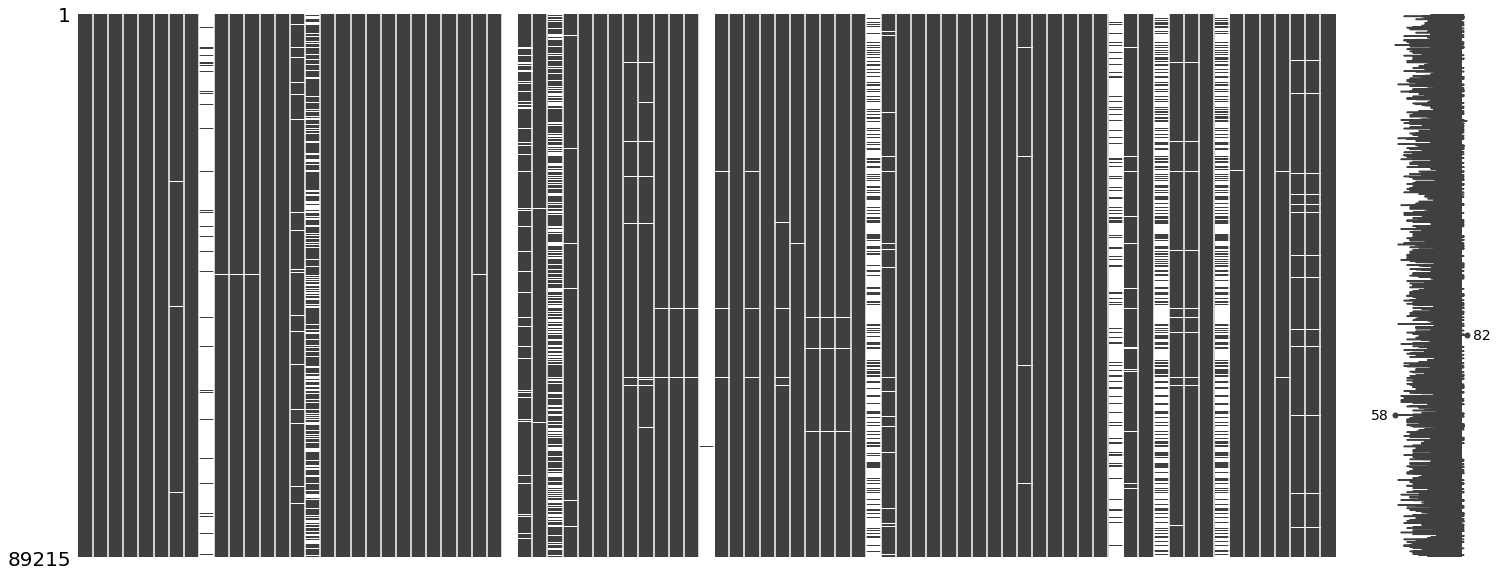

In [9]:
msno.matrix(df.sample(frac=.01));

Some columns present a considerable amount of null values, let's check more in detail:

In [10]:
missing_df = pd.concat([df.isnull().sum(), round(df.isnull().mean() * 100, 2)], axis=1)
missing_df.columns = ['missing_count', '%']
missing_df.sort_values(by='missing_count', ascending=False)[:15]

,missing_count,%
PuaMode,8919174,99.97
Census_ProcessorClass,8884852,99.59
DefaultBrowsersIdentifier,8488045,95.14
Census_IsFlightingInternal,7408759,83.04
Census_InternalBatteryType,6338429,71.05
Census_ThresholdOptIn,5667325,63.52
Census_IsWIMBootEnabled,5659703,63.44
SmartScreen,3177011,35.61
OrganizationIdentifier,2751518,30.84
SMode,537759,6.03


Let's make a list of features with more than 40% missing values:

In [11]:
missing_list = missing_df[missing_df['%']>40].index.tolist()
missing_list

['DefaultBrowsersIdentifier',
 'PuaMode',
 'Census_ProcessorClass',
 'Census_InternalBatteryType',
 'Census_IsFlightingInternal',
 'Census_ThresholdOptIn',
 'Census_IsWIMBootEnabled']

Drop variables with missing values > 40%:

In [12]:
df = df.drop(missing_list, axis=1)

Check for duplicates:

In [13]:
df.duplicated(keep=False).sum()

0

In [14]:
df['MachineIdentifier'].nunique(), df.shape[0]

(8921483, 8921483)

Get rid of MachineIdentifier:

In [15]:
df = df.drop('MachineIdentifier', axis=1)

In [16]:
df.shape

(8921483, 75)

Separate categorical and numerical data for analysis:

In [17]:
cat_col = df.select_dtypes('category').columns.tolist()
num_col = [col for col in df.columns.tolist() if col not in cat_col]

In [18]:
len(cat_col + num_col)

75

## Numerical data

In [19]:
df[num_col].head(10)

,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,...,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0,7.0,0,53447.0,1.0,1.0,1,29,128035.0,18.0,...,628.0,36144.0,0,0.0,0,0,0.0,0.0,10.0,0
1,0,7.0,0,53447.0,1.0,1.0,1,93,1482.0,18.0,...,628.0,57858.0,0,0.0,0,0,0.0,0.0,8.0,0
2,0,7.0,0,53447.0,1.0,1.0,1,86,153579.0,18.0,...,142.0,52682.0,0,0.0,0,0,0.0,0.0,3.0,0
3,0,7.0,0,53447.0,1.0,1.0,1,88,20710.0,NaN,...,355.0,20050.0,0,0.0,0,0,0.0,0.0,3.0,1
4,0,7.0,0,53447.0,1.0,1.0,1,18,37376.0,NaN,...,355.0,19844.0,0,0.0,0,0,0.0,0.0,1.0,1
5,0,7.0,0,53447.0,1.0,1.0,1,97,13598.0,27.0,...,93.0,51039.0,0,0.0,0,0,0.0,0.0,15.0,1
6,0,7.0,0,43927.0,2.0,1.0,1,78,81215.0,NaN,...,556.0,63175.0,1,0.0,0,0,0.0,0.0,10.0,1
7,0,7.0,0,53447.0,1.0,1.0,1,97,150323.0,27.0,...,512.0,63122.0,0,0.0,0,0,0.0,0.0,15.0,0
8,0,7.0,0,53447.0,1.0,1.0,1,164,155006.0,27.0,...,500.0,15510.0,0,0.0,0,0,0.0,0.0,15.0,0
9,0,7.0,0,46413.0,2.0,1.0,1,93,98572.0,27.0,...,556.0,63555.0,1,0.0,0,0,0.0,1.0,8.0,1


In [20]:
df[num_col].describe().T

,count,mean,std,min,25%,50%,75%,max
IsBeta,8921483.0,7.509962e-06,2.740421e-03,0.0,0.0,0.0,0.000000e+00,1.000000e+00
RtpStateBitfield,8889165.0,6.845333e+00,1.026055e+00,0.0,7.0,7.0,7.000000e+00,3.500000e+01
IsSxsPassiveMode,8921483.0,1.733378e-02,1.305118e-01,0.0,0.0,0.0,0.000000e+00,1.000000e+00
AVProductStatesIdentifier,8885262.0,4.784002e+04,1.403237e+04,3.0,49480.0,53447.0,5.344700e+04,7.050700e+04
AVProductsInstalled,8885262.0,1.326779e+00,5.229272e-01,0.0,1.0,1.0,2.000000e+00,7.000000e+00
AVProductsEnabled,8885262.0,1.020967e+00,1.675544e-01,0.0,1.0,1.0,1.000000e+00,5.000000e+00
HasTpm,8921483.0,9.879711e-01,1.090149e-01,0.0,1.0,1.0,1.000000e+00,1.000000e+00
CountryIdentifier,8921483.0,1.080490e+02,6.304706e+01,1.0,51.0,97.0,1.620000e+02,2.220000e+02
CityIdentifier,8596074.0,8.126650e+04,4.892339e+04,5.0,36825.0,82373.0,1.237000e+05,1.679620e+05
OrganizationIdentifier,6169965.0,2.486495e+01,5.605503e+00,1.0,18.0,27.0,2.700000e+01,5.200000e+01


Census_InternalPrimaryDisplayResolutionHorizontal and Census_InternalPrimaryDisplayResolutionVertical have -1 values. These should be considered as null values.

Many features here are ID's or categories encoded with numbers. It may be useful to change dtype to category and reduce the levels of categorical variables to avoid that the classifier could attribute more value to classes that are encoded with larger numbers, as ordinal encoding may be misleading in this case. 

Let's explore these features:

In [21]:
df.IsProtected.unique()

array([ 1.,  0., nan], dtype=float32)

IsProtected - This is a calculated field derived from the Spynet Report's AV Products field. Returns: a. TRUE if there is at least one active and up-to-date antivirus product running on this machine. b. FALSE if there is no active AV product on this machine, or if the AV is active, but is not receiving the latest updates. c. null if there are no Anti Virus Products in the report. Returns: Whether a machine is protected.

Ordinal encoding actually makes sense here:

In [22]:
df['IsProtected'] = df.IsProtected.map({np.nan:0.0, 0:1.0, 1:2.0}).astype('float')
df.IsProtected.unique()

array([2., 1., 0.])

In [23]:
binary_col = [col for col in num_col if df[col].nunique() <= 2]
df[binary_col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8921483 entries, 0 to 8921482
Data columns (total 16 columns):
 #   Column                                   Dtype  
---  ------                                   -----  
 0   IsBeta                                   int8   
 1   IsSxsPassiveMode                         int8   
 2   HasTpm                                   int8   
 3   AutoSampleOptIn                          int8   
 4   SMode                                    float32
 5   Firewall                                 float32
 6   Census_HasOpticalDiskDrive               int8   
 7   Census_IsPortableOperatingSystem         int8   
 8   Census_IsFlightsDisabled                 float32
 9   Census_IsSecureBootEnabled               int8   
 10  Census_IsVirtualDevice                   float32
 11  Census_IsTouchEnabled                    int8   
 12  Census_IsPenCapable                      int8   
 13  Census_IsAlwaysOnAlwaysConnectedCapable  float32
 14  Wdft_IsGamer      

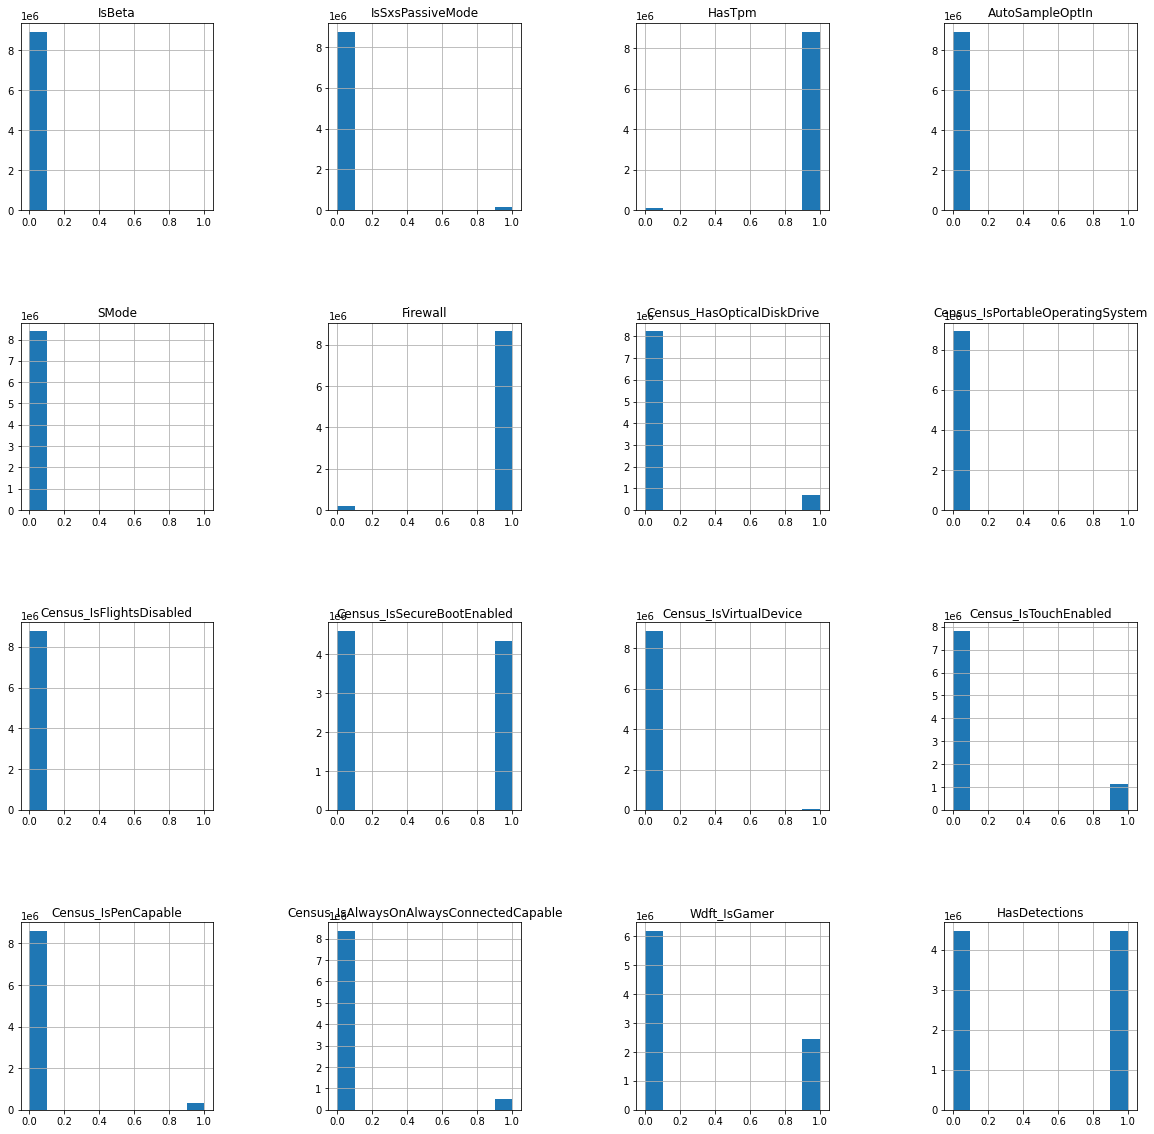

In [24]:
df[binary_col] = df[binary_col].astype('Int64')
df[binary_col].hist(figsize=(20, 20))
plt.subplots_adjust(hspace=.6, wspace=.6);

In [25]:
df[binary_col].var()

IsBeta                                     0.000008
IsSxsPassiveMode                           0.017033
HasTpm                                     0.011884
AutoSampleOptIn                            0.000029
SMode                                      0.000463
Firewall                                   0.020959
Census_HasOpticalDiskDrive                 0.071229
Census_IsPortableOperatingSystem           0.000545
Census_IsFlightsDisabled                   0.000010
Census_IsSecureBootEnabled                 0.249805
Census_IsVirtualDevice                     0.006990
Census_IsTouchEnabled                      0.109782
Census_IsPenCapable                        0.036622
Census_IsAlwaysOnAlwaysConnectedCapable    0.054122
Wdft_IsGamer                               0.203162
HasDetections                              0.250000
dtype: float64

In [26]:
[feat for feat in binary_col if df[feat].var() < 1e-4]

['IsBeta', 'AutoSampleOptIn', 'Census_IsFlightsDisabled']

In [27]:
IsBeta_contingency = pd.crosstab(df['IsBeta'], df['HasDetections'])
IsBeta_contingency

HasDetections,0,1
IsBeta,,
0,4462557,4458859
1,34,33


In [28]:
auto_smpl_contingency = pd.crosstab(df['AutoSampleOptIn'], df['HasDetections'])
auto_smpl_contingency

HasDetections,0,1
AutoSampleOptIn,,
0,4462474,4458751
1,117,141


In [29]:
flgt_dsbld_contingency = pd.crosstab(df['Census_IsFlightsDisabled'], df['HasDetections'])
flgt_dsbld_contingency

HasDetections,0,1
Census_IsFlightsDisabled,,
0,4383459,4377413
1,83,5


In [30]:
df.drop('IsBeta', axis=1, inplace=True)

Other numerical columns:

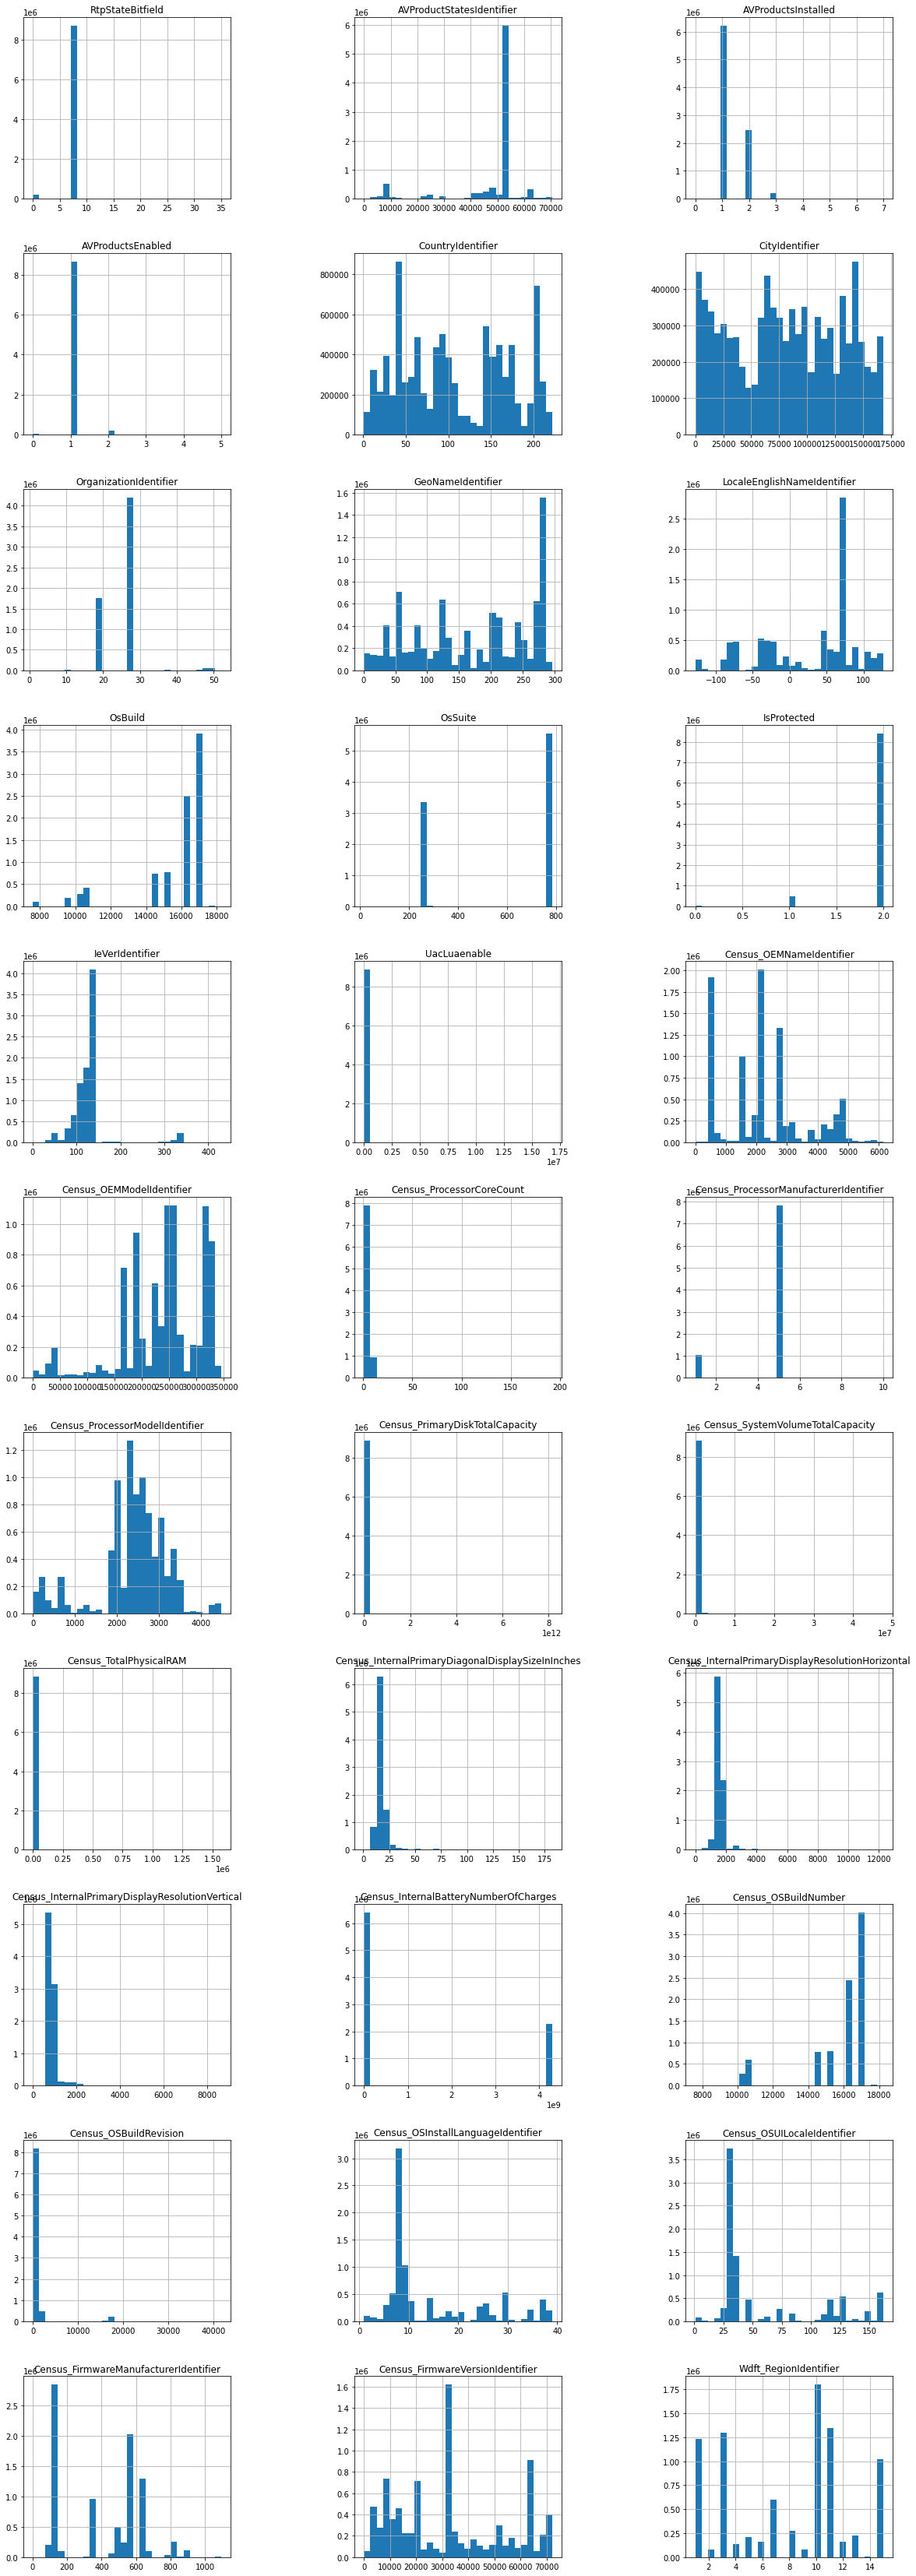

In [31]:
df.loc[:, ~df.columns.isin(binary_col)].hist(figsize=(20, 60), layout=(11, 3), bins=30)
plt.subplots_adjust(hspace=.3, wspace=.6)

Convert numerical columns which are actually categories to 'category' dtype.

In [32]:
df.RtpStateBitfield = df.RtpStateBitfield.astype('category')
df.AVProductsInstalled = df.AVProductsInstalled.astype('category')
df.AVProductsEnabled= df.AVProductsEnabled.astype('category')
df.UacLuaenable = df.UacLuaenable.astype('category')
df.OsBuild = df.OsBuild.astype('category')
df.OsSuite = df.OsSuite.astype('category')
df.Census_OSBuildNumber = df.Census_OSBuildNumber.astype('category')
df.Census_OSBuildRevision = df.Census_OSBuildRevision.astype('category')

id_col = [col for col in df.columns if 'Identifier' in col]
df[id_col] = df[id_col].astype('category')

## Summary of numerical features and potential issues:

**RtpStateBitfield**: no info in metadata. The most frequent value is 7.

**AVProductStatesIdentifier**: these are ID's for the specific configuration of a user's antivirus software. Should treat it as categorical feature. Most ID values around 53000.

**AVProductsInstalled** and **AVProductsEnabled**: no info in metadata. Probably a count of Anti Virus Products Installed and Enabled. Likely correlated. Most of values are 1 or 2 then large left skew.

**CountryIdentifier**, **CityIdentifier**, **GeoNameIdentifier**, **LocaleEnglishNameIdentifier**: these are all ID's taking many values and all related to location of a machine.

**OrganizationIdentifier**: ID for the organization the machine belongs in. Most values are 20 and 30, could reduce to three classes: 20, 30, others.

**OsBuild** and **OsSuite**: these are ID's of Product Build and Suite for the current operating system. OsSuite has mainly two classes.

**IeVerIdentifier**: no info in metadata. Has outliers.

**UacLuaenable**: has outliers.

**Census_OEMNameIdentifier**, **Census_OEMModelIdentifier**: no info in metadata. Should be ID for original equipment manufacturer OEM name and model.

**Census_ProcessorCoreCount**: Actual number of logical cores in the processor. Most machines have < 20 cores. There are outliers maybe because of supercomputers or workstations.

**Census_ProcessorManufacturerIdentifier**, **Census_ProcessorModelIdentifier**: no info in metadata. Should be ID for processor manufacturer and model.

**Census_PrimaryDiskTotalCapacity**, **Census_SystemVolumeTotalCapacity**, **Census_TotalPhysicalRAM**: these are actual numerics in MB of memory. They are likely correlated and have outliers.

**Census_InternalPrimaryDiagonalDisplaySizeInInches**, **Census_InternalPrimaryDisplayResolutionHorizontal**, **Census_InternalPrimaryDisplayResolutionVertical**: these are dims and resolution of display. Contain outliers.

**Census_InternalBatteryNumberOfCharges**: no info in metadata. It has mostly very small or very big values. Might convert it to binary feature.

All features with **"OS"** or **"Os"**, i.e. those related to Operating System, present repetitions since some of these have been extracted from OsVer and OsBuildLab. I will drop these repetitions.

**Census_FirmwareManufacturerIdentifier**, **Census_FirmwareVersionIdentifier**: no info in metadata. Should be ID's of Firmware Manufacturer and version.

**Wdft_RegionIdentifier**: no info in metadata. Should be another ID for Wdft_IsGamer.


## Key findings:

- Many features have outliers / extremely skewed distributions --> USE ML that are not sensitive to outliers, e.g. random forests;
- A few features are redundant / duplicates of other categorical features - see OS features --> remove correlated and redundant features (although random forests are immune to potential issues related to correlated feature, it's good practice to remove these, as they do not add any info);
- Most of the numerical features are actually categories / ID's encoded as numbers --> these need feature engineering and cardinality reduction;
- Actual numerical features are:
    - Census_ProcessorCoreCount
    - Census_PrimaryDiskTotalCapacity
    - Census_SystemVolumeTotalCapacity
    - Census_TotalPhysicalRAM
    - Census_InternalPrimaryDiagonalDisplaySizeInInches
    - Census_InternalPrimaryDisplayResolutionHorizontal
    - Census_InternalPrimaryDisplayResolutionVertical
    - Census_InternalBatteryNumberOfCharges

Let's fix some of these problems, starting with checking obvious outliers and skewed distributions (by obvious outliers here I mean gross errors, not necessarily all data points out of [Q1-1.5*IQR, Q3+1.5*IQR] or with a z-score > 3). I will add the features which are not useful for the analysis to the to_drop list and fix obvious outliers for the other features. 

**Census_ProcessorCoreCount**

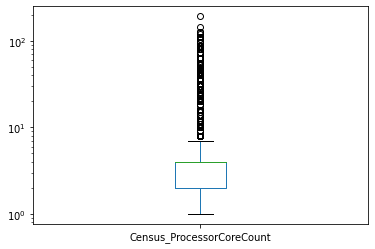

In [33]:
df.Census_ProcessorCoreCount.plot(kind='box')
plt.yscale('log');

Very few machines have more than 16 cores. 192 cores is possible for supercomputers. There aren't obvious outliers, simply most of the data describes machines that are below 8 cores.

**Census_PrimaryDiskTotalCapacity**

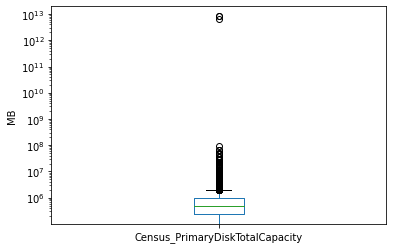

In [34]:
df.Census_PrimaryDiskTotalCapacity.plot(kind='box')
plt.yscale('log')
plt.ylabel('MB');

Other than the obvious outliers with capacity of $10^{13}$ MB, a number of machines have ~100 TB of disk space capacity. This was, in fact, the maximum SSD possible value in 2018, according to: https://en.wikipedia.org/wiki/Hard_disk_drive

Let's remove the two obvious outliers:

In [35]:
limit = 10**9
df.drop(df[df['Census_PrimaryDiskTotalCapacity'] > limit].index, inplace=True)

**Census_SystemVolumeTotalCapacity**

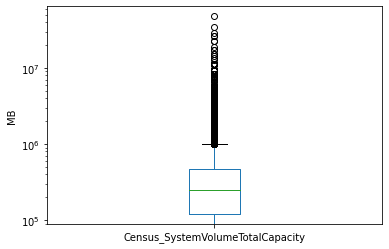

In [36]:
df.Census_SystemVolumeTotalCapacity.plot(kind='box')
plt.yscale('log')
plt.ylabel('MB');

**Census_TotalPhysicalRAM**

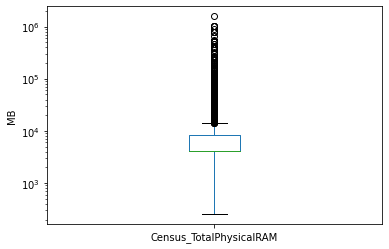

In [37]:
df.Census_TotalPhysicalRAM.plot(kind='box')
plt.yscale('log')
plt.ylabel('MB');

Outliers go from 16 to 160 TB, these are rare values but not necessarily mistakes. There are not obvious outliers.

**Census_InternalPrimaryDiagonalDisplaySizeInInches**

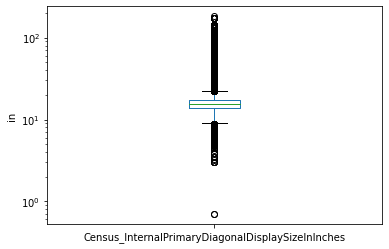

In [38]:
df.Census_InternalPrimaryDiagonalDisplaySizeInInches.plot(kind='box')
plt.yscale('log')
plt.ylabel('in');

Screens with diagonal > 80 inches are rare but a max of 140 inches is possible. Let's remove the obvious outlier, i.e. the data points < 1 in.

In [39]:
limit = 1
df.drop(df[df['Census_InternalPrimaryDiagonalDisplaySizeInInches'] < limit].index, inplace=True)

**Census_InternalPrimaryDisplayResolutionHorizontal** and **Census_InternalPrimaryDisplayResolutionVertical**


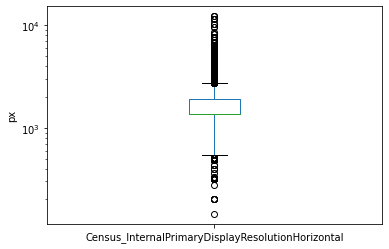

In [40]:
df.Census_InternalPrimaryDisplayResolutionHorizontal.plot(kind='box')
plt.yscale('log')
plt.ylabel('px');

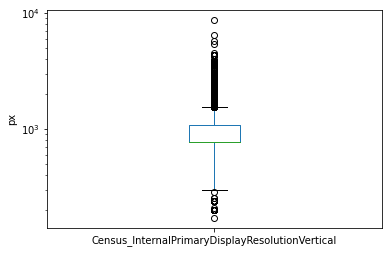

In [41]:
df.Census_InternalPrimaryDisplayResolutionVertical.plot(kind='box')
plt.yscale('log')
plt.ylabel('px');

There are not any obvious outliers but some values are -1. These will be changed to NaN.

In [42]:
df.loc[df.Census_InternalPrimaryDisplayResolutionHorizontal <= 0, 
       'Census_InternalPrimaryDisplayResolutionHorizontal'] = np.nan
df.loc[df.Census_InternalPrimaryDisplayResolutionVertical <= 0, 
       'Census_InternalPrimaryDisplayResolutionVertical'] = np.nan

**Census_InternalBatteryNumberOfCharges**

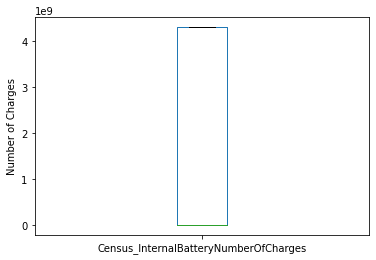

In [43]:
df.Census_InternalBatteryNumberOfCharges.plot(kind='box')
#plt.yscale('log')
plt.ylabel('Number of Charges');

In [44]:
battery_charges_count = df.Census_InternalBatteryNumberOfCharges.value_counts()
battery_charges_count[:20]

0.000000e+00    5053400
4.294967e+09    2263992
1.000000e+00      53810
2.000000e+00      28128
1.600000e+01      27348
3.000000e+00      21537
3.300000e+01      19723
4.000000e+00      18020
5.000000e+00      16190
6.000000e+00      14472
7.000000e+00      13506
8.000000e+00      12985
9.000000e+00      12020
3.740000e+02      11630
1.000000e+01      11518
1.100000e+01      11082
4.380000e+02      10707
1.200000e+01      10561
1.300000e+01       9965
1.400000e+01       9803
3.770000e+02       9716
1.500000e+01       9621
2.560000e+02       9582
2.600000e+01       9243
1.700000e+01       8937
1.800000e+01       8818
3.840000e+02       8691
1.900000e+01       8473
2.000000e+01       8322
Name: Census_InternalBatteryNumberOfCharges, dtype: int64

There is no info about this column, and most values are 0 or 4e9. Let's convert to categorical and reduce to 3 classes.

In [45]:
df.Census_InternalBatteryNumberOfCharges.isnull().sum()

268755

In [46]:
nans = df.Census_InternalBatteryNumberOfCharges.isnull()

In [47]:
df.loc[df.Census_InternalBatteryNumberOfCharges == 0, 'Census_InternalBatteryNumberOfCharges'] = 0
df.loc[(df.Census_InternalBatteryNumberOfCharges != 0) &
       (df.Census_InternalBatteryNumberOfCharges != df.Census_InternalBatteryNumberOfCharges.max()), 
       'Census_InternalBatteryNumberOfCharges'] = 'Other'
df.loc[nans, 'Census_InternalBatteryNumberOfCharges'] = np.nan
df.Census_InternalBatteryNumberOfCharges = df.Census_InternalBatteryNumberOfCharges.map({0.0:'None',
                                                                                        4294967296.0: 'Max',
                                                                                        'Other':'Other'}).astype('category')
df.Census_InternalBatteryNumberOfCharges.value_counts()

None     5053400
Max      2263992
Other    1335331
Name: Census_InternalBatteryNumberOfCharges, dtype: int64

#### Reassign dtypes and summary of data

In [48]:
df.shape

(8921478, 74)

In [49]:
num_col = ['Census_PrimaryDiskTotalCapacity', 
           'Census_SystemVolumeTotalCapacity',
           'Census_TotalPhysicalRAM',
           'Census_ProcessorCoreCount', 
           'Census_InternalPrimaryDiagonalDisplaySizeInInches',
           'Census_InternalPrimaryDisplayResolutionHorizontal',
           'Census_InternalPrimaryDisplayResolutionVertical']
binary_col = df.select_dtypes('Int64').columns.tolist()
cat_col = [col for col in df.columns
          if col not in num_col 
          if col not in binary_col]
df[cat_col] = df[cat_col][df[cat_col].notnull()].astype('str')
df[cat_col] = df[cat_col].astype('category')

In [50]:
len(num_col) + len(binary_col) + len(cat_col)

74

In [51]:
df.shape

(8921478, 74)

# Categorical Features

In [52]:
df[cat_col].head()

,ProductName,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,CountryIdentifier,CityIdentifier,...,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_FlightRing,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Wdft_RegionIdentifier
0,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,7.0,53447.0,1.0,1.0,29,128035.0,...,UUPUpgrade,26.0,119,UNKNOWN,IS_GENUINE,Retail,Retail,628.0,36144.0,10.0
1,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,7.0,53447.0,1.0,1.0,93,1482.0,...,IBSClean,8.0,31,UNKNOWN,OFFLINE,Retail,NOT_SET,628.0,57858.0,8.0
2,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,7.0,53447.0,1.0,1.0,86,153579.0,...,UUPUpgrade,7.0,30,FullAuto,IS_GENUINE,OEM:NONSLP,Retail,142.0,52682.0,3.0
3,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1527.0,7.0,53447.0,1.0,1.0,88,20710.0,...,UUPUpgrade,17.0,64,FullAuto,IS_GENUINE,OEM:NONSLP,Retail,355.0,20050.0,3.0
4,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1379.0,7.0,53447.0,1.0,1.0,18,37376.0,...,Update,8.0,31,FullAuto,IS_GENUINE,Retail,Retail,355.0,19844.0,1.0


In [53]:
df[cat_col].describe().T

,count,unique,top,freq
ProductName,8921478,6,win8defender,8826515
EngineVersion,8921478,70,1.1.15200.1,3845063
AppVersion,8921478,110,4.18.1807.18075,5139221
AvSigVersion,8921478,8531,1.273.1420.0,102317
RtpStateBitfield,8889160,7,7.0,8651482
AVProductStatesIdentifier,8885257,28970,53447.0,5824561
AVProductsInstalled,8885257,8,1.0,6208889
AVProductsEnabled,8885257,6,1.0,8654096
CountryIdentifier,8921478,222,43,397172
CityIdentifier,8596069,107366,130775.0,94812


In [54]:
for col in cat_col:
    print(f'''
Feature: {col} 
Unique Values Count: {df[col].nunique()}
Missing Values Count: {df[col].isnull().sum()}
Value counts: 
{df[col].value_counts()}
''')   


Feature: ProductName 
Unique Values Count: 6
Missing Values Count: 0
Value counts: 
win8defender     8826515
mse                94873
mseprerelease         53
scep                  22
windowsintune          8
fep                    7
Name: ProductName, dtype: int64


Feature: EngineVersion 
Unique Values Count: 70
Missing Values Count: 0
Value counts: 
1.1.15200.1    3845063
1.1.15100.1    3675914
1.1.15000.2     265218
1.1.14901.4     212408
1.1.14600.4     160585
                ...   
1.1.13301.0          2
1.1.12802.0          1
1.1.11202.0          1
1.1.11104.0          1
1.1.10701.0          1
Name: EngineVersion, Length: 70, dtype: int64


Feature: AppVersion 
Unique Values Count: 110
Missing Values Count: 0
Value counts: 
4.18.1807.18075    5139221
4.18.1806.18062     850929
4.12.16299.15       359871
4.10.209.0          272454
4.13.17134.1        257270
                    ...   
4.13.17134.226           1
4.8.203.0                1
4.8.10240.17943          1
4.17.17686.1004


Feature: SkuEdition 
Unique Values Count: 8
Missing Values Count: 0
Value counts: 
Home               5514337
Pro                3224163
Invalid              78054
Education            40694
Enterprise           34357
Enterprise LTSB      20702
Cloud                 5589
Server                3582
Name: SkuEdition, dtype: int64


Feature: IsProtected 
Unique Values Count: 3
Missing Values Count: 0
Value counts: 
2.0    8402277
1.0     483157
0.0      36044
Name: IsProtected, dtype: int64


Feature: IeVerIdentifier 
Unique Values Count: 303
Missing Values Count: 58894
Value counts: 
137.0    3885840
117.0    1767931
108.0     474390
111.0     467828
98.0      354410
          ...   
200.0          1
404.0          1
402.0          1
40.0           1
380.0          1
Name: IeVerIdentifier, Length: 303, dtype: int64


Feature: SmartScreen 
Unique Values Count: 21
Missing Values Count: 3177010
Value counts: 
RequireAdmin    4316180
ExistsNotSet    1046182
Off              186553
Warn     


Feature: Census_OSBuildNumber 
Unique Values Count: 165
Missing Values Count: 0
Value counts: 
17134    4008879
16299    2443249
15063     797049
14393     785449
10586     593526
          ...   
14314          1
14306          1
14300          1
14298          1
14425          1
Name: Census_OSBuildNumber, Length: 165, dtype: int64


Feature: Census_OSBuildRevision 
Unique Values Count: 285
Missing Values Count: 0
Value counts: 
228      1413633
165       899712
431       546548
285       470278
547       346853
          ...   
488            1
1232           1
596            1
691            1
23418          1
Name: Census_OSBuildRevision, Length: 285, dtype: int64


Feature: Census_OSEdition 
Unique Values Count: 33
Missing Values Count: 0
Value counts: 
Core                           3469988
Professional                   3130565
CoreSingleLanguage             1945460
CoreCountrySpecific             166100
ProfessionalEducation            56698
Education                        4

Some categorical variables have rare classes, others have lots of classes equally frequent. Let's look at these high cardinality featurtes more in detail.

In [55]:
n_unique_list = df[cat_col].nunique().sort_values(ascending=False)
n_unique_list[:20]

Census_OEMModelIdentifier                175364
CityIdentifier                           107366
Census_FirmwareVersionIdentifier          50493
AVProductStatesIdentifier                 28970
AvSigVersion                               8531
Census_OEMNameIdentifier                   3832
Census_ProcessorModelIdentifier            3428
Census_FirmwareManufacturerIdentifier       712
OsBuildLab                                  663
Census_OSVersion                            469
IeVerIdentifier                             303
GeoNameIdentifier                           292
Census_OSBuildRevision                      285
LocaleEnglishNameIdentifier                 252
CountryIdentifier                           222
Census_OSBuildNumber                        165
Census_OSUILocaleIdentifier                 147
AppVersion                                  110
OsBuild                                      76
EngineVersion                                70
dtype: int64

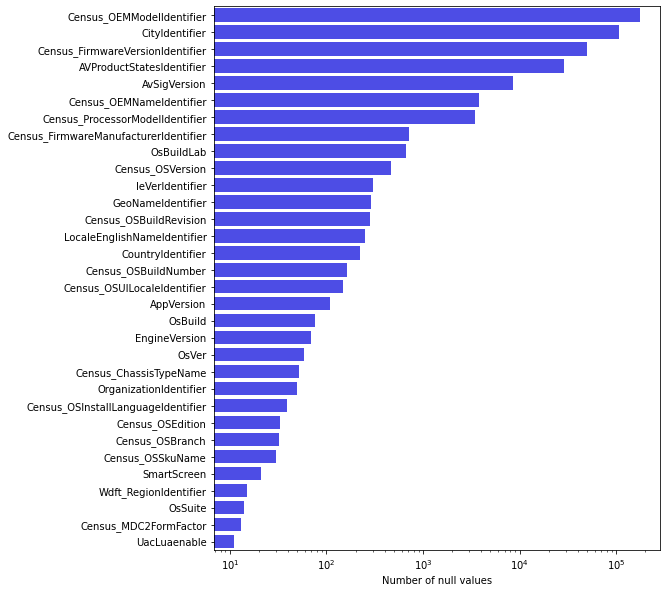

In [56]:
high_cardinality_features = n_unique_list[n_unique_list > 10]
plt.figure(figsize=(8,10))
sns.barplot(y=high_cardinality_features.index, 
            x=high_cardinality_features.values, 
            orient='h', 
            color='b', 
            alpha=.8)
plt.xscale('log')
plt.xlabel('Number of null values');

Let's reduce the number of levels of the features with high cardinality, this hopefully makes the future machine learning models more robust and less prone to overfit or suffer the curse of dimensionality.  

#### AvSigVersion

In [57]:
df['AvSigVersion'].isnull().sum()

0

In [58]:
av_sig_ver = pd.concat([df['AvSigVersion'].value_counts(),
                        df['AvSigVersion'].value_counts(normalize=True) * 100], 
                        axis=1)
av_sig_ver.columns=['Count', '%']
av_sig_ver.head(20)

,Count,%
1.273.1420.0,102317,1.146862
1.263.48.0,98024,1.098742
1.275.1140.0,97231,1.089853
1.275.727.0,92448,1.036241
1.273.371.0,86967,0.974805
1.273.1826.0,86013,0.964112
1.275.1244.0,78902,0.884405
1.251.42.0,76837,0.861259
1.275.1209.0,66393,0.744193
1.273.810.0,65895,0.738611


In [59]:
idx = df['AvSigVersion'][~df.AvSigVersion.str.startswith('1')].index
df['AvSigVersion'].loc[idx]

110258     0.0.0.0
152561     0.0.0.0
165482     0.0.0.0
475422     0.0.0.0
549779     0.0.0.0
            ...   
8261662    0.0.0.0
8361401    0.0.0.0
8394149    0.0.0.0
8566717    0.0.0.0
8602753    0.0.0.0
Name: AvSigVersion, Length: 68, dtype: category
Categories (8531, object): ['0.0.0.0', '1.155.266.0', '1.167.387.0', '1.169.1625.0', ..., '1.277.58.0', '1.277.62.0', '1.277.64.0', '1.277.67.0']

In [60]:
df['AvSigVersion_extracted'] = [item[1] for item in df.AvSigVersion.str.split('.')]
df['AvSigVersion_extracted'] = df['AvSigVersion_extracted'].astype('category')
df[['AvSigVersion','AvSigVersion_extracted']]

,AvSigVersion,AvSigVersion_extracted
0,1.273.1735.0,273
1,1.263.48.0,263
2,1.273.1341.0,273
3,1.273.1527.0,273
4,1.273.1379.0,273
...,...,...
8921478,1.273.1555.0,273
8921479,1.233.4218.0,233
8921480,1.275.1242.0,275
8921481,1.269.1834.0,269


In [61]:
av_sig_ver = pd.concat([df['AvSigVersion_extracted'].value_counts(),
                        df['AvSigVersion_extracted'].value_counts(normalize=True) * 100], 
                        axis=1)
av_sig_ver.columns=['Count', '%']
av_sig_ver.head(10)

,Count,%
275,3901024,43.726208
273,3724333,41.745695
271,269369,3.019332
269,214502,2.404333
263,160659,1.800811
267,138899,1.556906
251,94182,1.055677
277,79719,0.893563
237,70628,0.791663
261,48790,0.546882


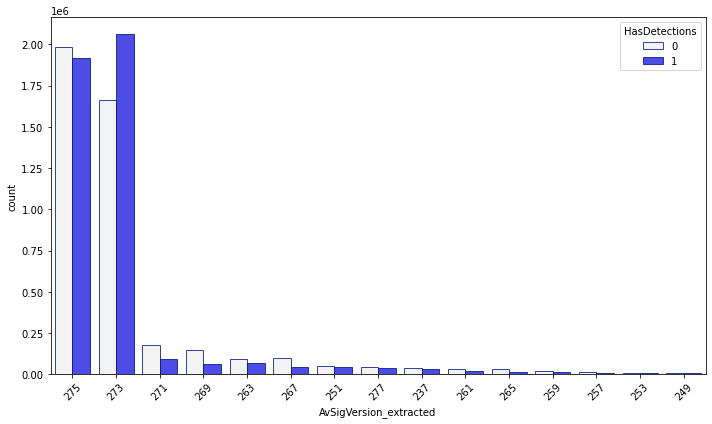

In [62]:
plt.figure(figsize=(10, 6))
sns.countplot(x='AvSigVersion_extracted',
            hue='HasDetections',
            data=df,
            order=df['AvSigVersion_extracted'].value_counts().index[:15],
            color='blue',
            edgecolor=sns.color_palette('dark', 1),
            alpha=0.8)
plt.legend(loc=1, title='HasDetections')
plt.xticks(rotation = 45)
plt.tight_layout()

In [63]:
df['AvSigVersion_extracted'].dtype

CategoricalDtype(categories=['0', '155', '167', '169', '177', '187', '189', '193', '195',
                  '197', '199', '2&#x17;3', '201', '203', '205', '207', '209',
                  '211', '213', '215', '217', '219', '221', '223', '225',
                  '227', '229', '231', '233', '235', '237', '239', '241',
                  '243', '245', '247', '249', '251', '253', '255', '257',
                  '259', '261', '263', '265', '267', '269', '271', '273',
                  '275', '277'],
, ordered=False)

In [64]:
df['AvSigVersion_extracted'] = df['AvSigVersion_extracted'].astype('category')
df['AvSigVersion_extracted'].cat.add_categories('Other', inplace=True)
df.loc[(df['AvSigVersion_extracted'] != '275') & (df['AvSigVersion_extracted'] != '273'), 
       'AvSigVersion_extracted'] = 'Other'
df['AvSigVersion_extracted'].cat.remove_unused_categories(inplace=True)
df.rename(columns={'AvSigVersion_extracted':'AvSigVersion_encoded'}, inplace=True)
df['AvSigVersion_encoded'].value_counts(normalize=True)

275      0.437262
273      0.417457
Other    0.145281
Name: AvSigVersion_encoded, dtype: float64

In [65]:
to_drop = []
to_drop.append('AvSigVersion')

#### Census_OSVersion


In [66]:
df['Census_OSVersion'].isnull().sum()

0

In [67]:
census_os_ver = pd.concat([df['Census_OSVersion'].value_counts(),
                        df['Census_OSVersion'].value_counts(normalize=True) * 100], 
                        axis=1)
census_os_ver.columns=['Count', '%']
census_os_ver.head(20)

,Count,%
10.0.17134.228,1413627,15.845211
10.0.17134.165,899711,10.084775
10.0.16299.431,546546,6.126182
10.0.17134.285,470278,5.271301
10.0.16299.547,346853,3.887842
10.0.17134.112,346410,3.882877
10.0.16299.371,325267,3.645887
10.0.17134.191,228254,2.558477
10.0.14393.2189,223774,2.508262
10.0.16299.611,216776,2.429822


In [68]:
sum(~df.Census_OSVersion.str.startswith('10.0.'))

20

In [69]:
idx = df['Census_OSVersion'][~df.Census_OSVersion.str.startswith('10')].index
df['Census_OSVersion'].loc[idx]

539238     6.3.9600.19102
570167     6.1.7601.24241
667694     6.2.9200.17617
1370982    6.3.9600.19069
1485064    6.3.9600.19069
1549235    6.2.9200.17617
2927703    6.2.9200.17581
3183570    6.3.9600.18687
3336222    6.3.9600.19102
4035016    6.1.7601.24149
4813273    6.3.9600.19102
5593621    6.3.9600.19069
5889449    6.3.9600.18778
6422191    6.1.7601.24241
6758081    6.1.7601.24214
6895980    6.3.9600.18756
7611545    6.1.7601.23418
8266291    6.3.9600.19069
8370072    6.3.9600.19102
8743609    6.2.9200.21703
Name: Census_OSVersion, dtype: category
Categories (469, object): ['10.0.10240.16384', '10.0.10240.16387', '10.0.10240.16389', '10.0.10240.16391', ..., '6.3.9600.18756', '6.3.9600.18778', '6.3.9600.19069', '6.3.9600.19102']

In [70]:
len(idx)

20

OS Version 6 is rare, just 20 cases. All the others are ver 10.0. 
Of these we can extract the 5-digit build code after "10.0.". 

In [71]:
df['Census_OSVersion_extracted'] = [item[2] for item in df.Census_OSVersion.str.split('.')]
df['Census_OSVersion_extracted'] = df['Census_OSVersion_extracted'].astype('category')
df[['Census_OSVersion', 'Census_OSVersion_extracted']]

,Census_OSVersion,Census_OSVersion_extracted
0,10.0.17134.165,17134
1,10.0.17134.1,17134
2,10.0.17134.165,17134
3,10.0.17134.228,17134
4,10.0.17134.191,17134
...,...,...
8921478,10.0.16299.431,16299
8921479,10.0.10586.679,10586
8921480,10.0.16299.371,16299
8921481,10.0.15063.483,15063


This is probably the build number, which was already included in the features. I will check on this later when I analyze the OS features.

In [72]:
to_drop.append('Census_OSVersion')

#### AppVersion

In [73]:
df['AppVersion'].isnull().sum()

0

In [74]:
app_ver = pd.concat([df['AppVersion'].value_counts(),
                        df['AppVersion'].value_counts(normalize=True) * 100], 
                        axis=1)
app_ver.columns=['Count', '%']
app_ver.head(20)

,Count,%
4.18.1807.18075,5139221,57.605040
4.18.1806.18062,850929,9.537982
4.12.16299.15,359871,4.033760
4.10.209.0,272454,3.053911
4.13.17134.1,257270,2.883715
4.16.17656.18052,235032,2.634451
4.13.17134.228,226501,2.538828
4.8.10240.17443,205479,2.303195
4.9.10586.1106,203525,2.281292
4.14.17639.18041,194699,2.182363


In [75]:
idx = df['AppVersion'][~df.AppVersion.str.startswith('4')].index
df['AppVersion'].loc[idx]

Series([], Name: AppVersion, dtype: category
Categories (110, object): ['4.10.14393.0', '4.10.14393.1066', '4.10.14393.1198', '4.10.14393.1532', ..., '4.9.10586.962', '4.9.10586.965', '4.9.218.0', '4.9.219.0'])

The AppVersion is always 4, I'll extract code after "4.".


In [76]:
df['AppVersion_extracted'] = [item[1] for item in df.AppVersion.str.split('.')]
df['AppVersion_extracted'] = df['AppVersion_extracted'].astype('category')
df[['AppVersion','AppVersion_extracted']]

,AppVersion,AppVersion_extracted
0,4.18.1807.18075,18
1,4.13.17134.1,13
2,4.18.1807.18075,18
3,4.18.1807.18075,18
4,4.18.1807.18075,18
...,...,...
8921478,4.18.1807.18075,18
8921479,4.9.10586.672,9
8921480,4.18.1807.18075,18
8921481,4.16.17656.18052,16


In [77]:
app_ver = pd.concat([df['AppVersion_extracted'].value_counts(),
                     df['AppVersion_extracted'].value_counts(normalize=True) * 100], 
                        axis=1)
app_ver.columns=['Count', '%']
app_ver.head(30)

,Count,%
18,6004752,67.306695
12,553556,6.204757
13,518592,5.812848
10,457718,5.130518
9,417039,4.674551
8,275738,3.090721
14,248765,2.788383
16,235060,2.634765
11,205271,2.300863
5,2261,0.025343


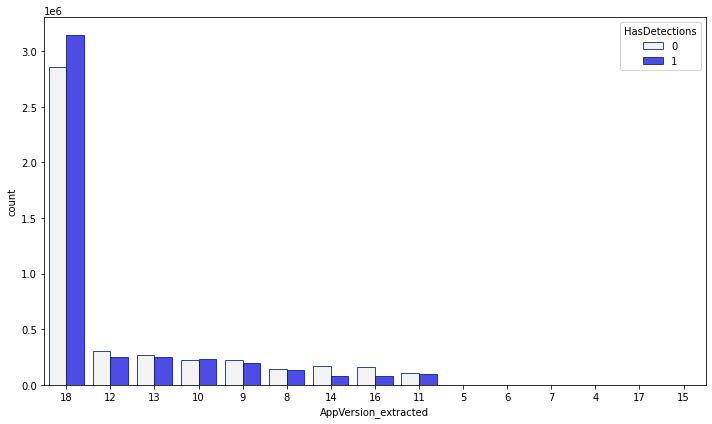

In [78]:
plt.figure(figsize=(10, 6))
sns.countplot(x='AppVersion_extracted',
            hue='HasDetections',
            data=df,
            order=df['AppVersion_extracted'].value_counts().index[:15],
            color='blue',
            edgecolor=sns.color_palette('dark', 1),
            alpha=0.8)
plt.legend(loc=1, title='HasDetections')
plt.tight_layout()

In [79]:
df['AppVersion_extracted'].dtype

CategoricalDtype(categories=['10', '11', '12', '13', '14', '15', '16', '17', '18', '4',
                  '5', '6', '7', '8', '9'],
, ordered=False)

In [80]:
df['AppVersion_extracted'].cat.add_categories('Other', inplace=True)
df.loc[(df['AppVersion_extracted'] != '18') &
       (df['AppVersion_extracted'] != '12') &
       (df['AppVersion_extracted'] != '13') &
       (df['AppVersion_extracted'] != '10') &
       (df['AppVersion_extracted'] != '9') &
       (df['AppVersion_extracted'] != '8') &
       (df['AppVersion_extracted'] != '14') &
       (df['AppVersion_extracted'] != '16') &
       (df['AppVersion_extracted'] != '11'), 
       'AppVersion_extracted'] = 'Other'
df['AppVersion_extracted'].cat.remove_unused_categories(inplace=True)
df.rename(columns={'AppVersion_extracted':'AppVersion_encoded'}, inplace=True)
df['AppVersion_encoded'].value_counts(normalize=True)

18       0.673067
12       0.062048
13       0.058128
10       0.051305
9        0.046746
8        0.030907
14       0.027884
16       0.026348
11       0.023009
Other    0.000559
Name: AppVersion_encoded, dtype: float64

In [81]:
to_drop.append('AppVersion')

#### EngineVersion

In [82]:
df['EngineVersion'].isnull().sum()

0

In [83]:
eng_ver = pd.concat([df['EngineVersion'].value_counts(),
                     df['EngineVersion'].value_counts(normalize=True) * 100], 
                     axis=1)
eng_ver.columns=['Count', '%']
eng_ver.head(20)

,Count,%
1.1.15200.1,3845063,43.098946
1.1.15100.1,3675914,41.202971
1.1.15000.2,265218,2.972803
1.1.14901.4,212408,2.380861
1.1.14600.4,160585,1.799982
1.1.14800.3,136476,1.529747
1.1.15300.6,120295,1.348375
1.1.14104.0,93926,1.052808
1.1.13504.0,70645,0.791853
1.1.15300.5,68716,0.770231


In [84]:
idx = df['EngineVersion'][~df.EngineVersion.str.startswith('1.1.')].index
df['EngineVersion'].loc[idx]

Series([], Name: EngineVersion, dtype: category
Categories (70, object): ['1.1.10302.0', '1.1.10401.0', '1.1.10701.0', '1.1.11104.0', ..., '1.1.15200.1', '1.1.15300.5', '1.1.15300.6', '1.1.9700.0'])

Let's extract the 5-digit code after "1.1.".

In [85]:
df['EngineVersion_extracted'] = [item[2] for item in df.EngineVersion.str.split('.')]
df['EngineVersion_extracted'] = df['EngineVersion_extracted'].astype('category')
df[['EngineVersion','EngineVersion_extracted']]

,EngineVersion,EngineVersion_extracted
0,1.1.15100.1,15100
1,1.1.14600.4,14600
2,1.1.15100.1,15100
3,1.1.15100.1,15100
4,1.1.15100.1,15100
...,...,...
8921478,1.1.15100.1,15100
8921479,1.1.13303.0,13303
8921480,1.1.15200.1,15200
8921481,1.1.14901.4,14901


In [86]:
eng_ver = pd.concat([df['EngineVersion_extracted'].value_counts(),
                     df['EngineVersion_extracted'].value_counts(normalize=True) * 100], 
                        axis=1)
eng_ver.columns=['Count', '%']
eng_ver.head(10)

,Count,%
15200,3845063,43.098946
15100,3675914,41.202971
15000,267690,3.000512
14901,214039,2.399143
15300,189011,2.118606
14600,160585,1.799982
14800,137447,1.540630
14104,93926,1.052808
13504,70645,0.791853
14700,49210,0.551590


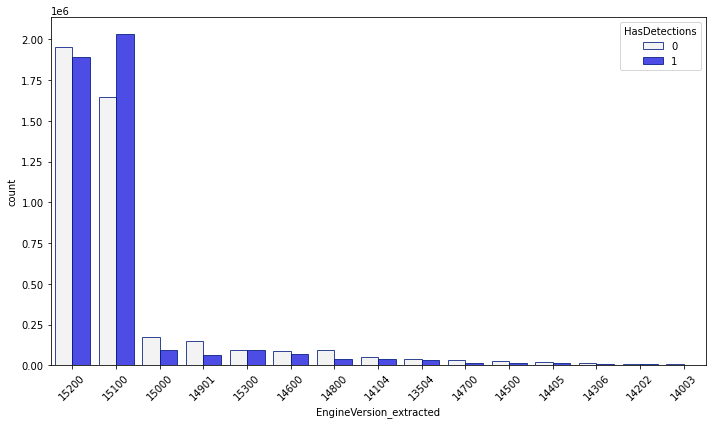

In [87]:
plt.figure(figsize=(10, 6))
sns.countplot(x='EngineVersion_extracted',
            hue='HasDetections',
            data=df,
            order=df['EngineVersion_extracted'].value_counts().index[:15],
            color='blue',
            edgecolor=sns.color_palette('dark', 1),
            alpha=0.8)
plt.legend(loc=1, title='HasDetections')
plt.xticks(rotation = 45)
plt.tight_layout()

In [88]:
df['EngineVersion_extracted'].dtype

CategoricalDtype(categories=['10302', '10401', '10701', '11104', '11202', '11400',
                  '11502', '11602', '11701', '11804', '11903', '12002',
                  '12101', '12205', '12300', '12400', '12505', '12603',
                  '12706', '12802', '12804', '12805', '12902', '13000',
                  '13102', '13103', '13202', '13301', '13303', '13406',
                  '13407', '13503', '13504', '13601', '13701', '13704',
                  '13802', '13803', '13804', '13902', '13903', '14001',
                  '14002', '14003', '14102', '14103', '14104', '14201',
                  '14202', '14303', '14305', '14306', '14405', '14500',
                  '14600', '14700', '14800', '14901', '15000', '15100',
                  '15200', '15300', '9700'],
, ordered=False)

In [89]:
df['EngineVersion_extracted'].cat.add_categories('Other', inplace=True)
df.loc[(df['EngineVersion_extracted'] != '15200') &
       (df['EngineVersion_extracted'] != '15100') &
       (df['EngineVersion_extracted'] != '15000') &
       (df['EngineVersion_extracted'] != '14901') &
       (df['EngineVersion_extracted'] != '15300') &
       (df['EngineVersion_extracted'] != '14600') &
       (df['EngineVersion_extracted'] != '14800') &
       (df['EngineVersion_extracted'] != '14104') &
       (df['EngineVersion_extracted'] != '13504'), 
       'EngineVersion_extracted'] = 'Other'
df['EngineVersion_extracted'].cat.remove_unused_categories(inplace=True)
df.rename(columns={'EngineVersion_extracted':'EngineVersion_encoded'}, inplace=True)
df['EngineVersion_encoded'].value_counts(normalize=True)

15200    0.430989
15100    0.412030
15000    0.030005
Other    0.029945
14901    0.023991
15300    0.021186
14600    0.018000
14800    0.015406
14104    0.010528
13504    0.007919
Name: EngineVersion_encoded, dtype: float64

In [90]:
to_drop.append('EngineVersion')

#### OsVer

In [91]:
df['OsVer'].isnull().sum()

0

In [92]:
os_ver = pd.concat([df['OsVer'].value_counts(),
                     df['OsVer'].value_counts(normalize=True) * 100], 
                     axis=1)
os_ver.columns=['Count', '%']
os_ver.head(20)

,Count,%
10.0.0.0,8632541,96.761333
6.3.0.0,194446,2.179527
6.1.1.0,93268,1.045432
6.1.0.0,582,0.006524
10.0.3.0,225,0.002522
10.0.1.0,141,0.001580
10.0.2.0,30,0.000336
6.1.3.0,30,0.000336
6.3.3.0,24,0.000269
10.0.32.72,23,0.000258


In [93]:
pd.crosstab(df.OsVer, df.HasDetections).head(10)

HasDetections,0,1
OsVer,,
10.0.0.0,4318188,4314353
10.0.0.1,3,2
10.0.0.112,6,4
10.0.0.2,0,1
10.0.0.22,1,0
10.0.0.3,2,0
10.0.0.80,0,1
10.0.0.96,0,1
10.0.1.0,62,79


In [94]:
versions = ['6.1', '6.3', '10.0']
for ver in versions:
    df.loc[df.OsVer.str.startswith(ver), 'OsVer_encoded'] = ver

In [95]:
df['OsVer_encoded'] = df['OsVer_encoded'].astype('category')
df['OsVer_encoded'].value_counts()

10.0    8633082
6.3      194507
6.1       93889
Name: OsVer_encoded, dtype: int64

In [96]:
to_drop.append('OsVer')

#### Census_ChassisTypeName

In [97]:
df['Census_ChassisTypeName'].isnull().sum()

623

In [98]:
nans = df['Census_ChassisTypeName'].isnull()

In [99]:
census_chassis = pd.concat([df['Census_ChassisTypeName'].value_counts(), 
                            df['Census_ChassisTypeName'].value_counts(normalize=True) * 100], 
                            axis=1)
census_chassis.columns=['Count', '%']
census_chassis.head(10)

,Count,%
Notebook,5248809,58.837511
Desktop,1872125,20.985937
Laptop,685581,7.685149
Portable,360903,4.045610
AllinOne,204295,2.290083
MiniTower,85127,0.954247
Convertible,84472,0.946905
Other,75780,0.849470
UNKNOWN,67212,0.753426
Detachable,51466,0.576918


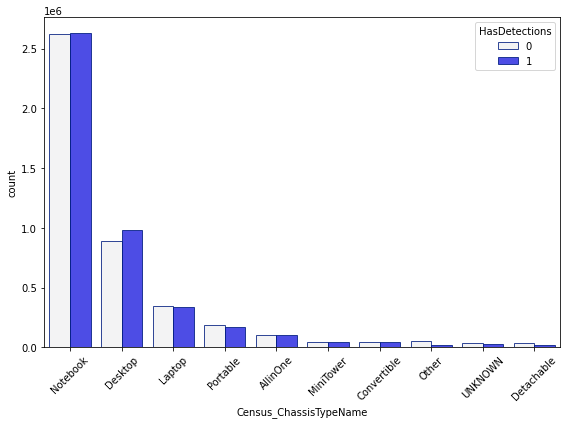

In [100]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Census_ChassisTypeName',
            hue='HasDetections',
            data=df,
            order=df['Census_ChassisTypeName'].value_counts().index[:10],
            color='blue',
            edgecolor=sns.color_palette('dark', 1),
            alpha=0.8)
plt.legend(loc=1, title='HasDetections')
plt.xticks(rotation = 45)
plt.tight_layout()

In [101]:
df['Census_ChassisTypeName'].dtype

CategoricalDtype(categories=['0', '112', '127', '25', '28', '30', '31', '32', '35', '36',
                  '39', '44', '45', '49', '76', '81', '82', '88', 'AllinOne',
                  'Blade', 'BladeEnclosure', 'BusExpansionChassis',
                  'CompactPCI', 'Convertible', 'Desktop', 'Detachable',
                  'DockingStation', 'EmbeddedPC', 'ExpansionChassis',
                  'HandHeld', 'IoTGateway', 'Laptop', 'LowProfileDesktop',
                  'LunchBox', 'MainServerChassis', 'MiniPC', 'MiniTower',
                  'MultisystemChassis', 'Notebook', 'Other', 'PizzaBox',
                  'Portable', 'RackMountChassis', 'SealedCasePC',
                  'SpaceSaving', 'StickPC', 'SubChassis', 'SubNotebook',
                  'Tablet', 'Tower', 'UNKNOWN', 'Unknown'],
, ordered=False)

In [102]:
df.loc[(df['Census_ChassisTypeName'] != 'Notebook') &
       (df['Census_ChassisTypeName'] != 'Desktop') &
       (df['Census_ChassisTypeName'] != 'Laptop') &
       (df['Census_ChassisTypeName'] != 'Portable') &
       (df['Census_ChassisTypeName'] != 'AllinOne') &
       (df['Census_ChassisTypeName'] != 'MiniTower') &
       (df['Census_ChassisTypeName'] != 'Convertible'), 
       'Census_ChassisTypeName'] = 'Other'
df['Census_ChassisTypeName'].cat.remove_unused_categories(inplace=True)
df.loc[nans, 'Census_ChassisTypeName'] = np.nan
df['Census_ChassisTypeName'] = df['Census_ChassisTypeName'].astype('category')
df.rename(columns={'Census_ChassisTypeName':'Census_ChassisTypeName_encoded'}, inplace=True)
df['Census_ChassisTypeName_encoded'].value_counts(normalize=True)

Notebook       0.588375
Desktop        0.209859
Laptop         0.076851
Other          0.042546
Portable       0.040456
AllinOne       0.022901
MiniTower      0.009542
Convertible    0.009469
Name: Census_ChassisTypeName_encoded, dtype: float64

In [103]:
df['Census_ChassisTypeName_encoded'].isnull().sum()

623

#### Census_OSEdition

In [104]:
df['Census_OSEdition'].isnull().sum()

0

In [105]:
census_os_edition = pd.concat([df['Census_OSEdition'].value_counts(),
                               df['Census_OSEdition'].value_counts(normalize=True) * 100], 
                               axis=1)
census_os_edition.columns=['Count', '%']
census_os_edition.head(10)

,Count,%
Core,3469988,38.894766
Professional,3130565,35.090206
CoreSingleLanguage,1945460,21.806476
CoreCountrySpecific,166100,1.861799
ProfessionalEducation,56698,0.635522
Education,40704,0.456247
Enterprise,35603,0.399071
ProfessionalN,28341,0.317672
EnterpriseS,20020,0.224402
ServerStandard,10128,0.113524


In [106]:
df.loc[df.Census_OSEdition == 'professional', 'Census_OSEdition'] = 'Professional'
df.Census_OSEdition.cat.remove_categories('professional', inplace=True)

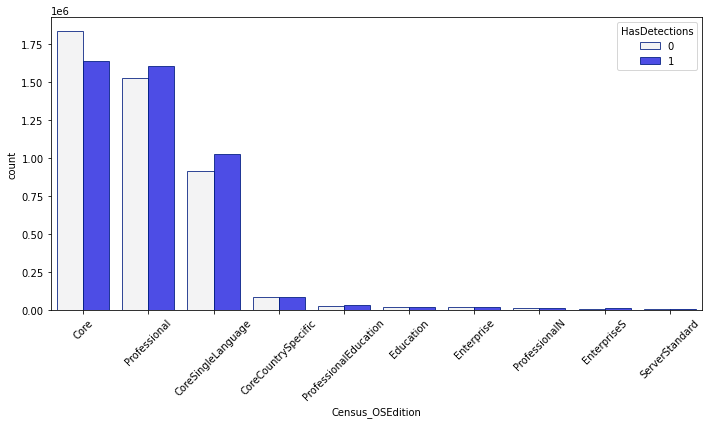

In [107]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Census_OSEdition',
            hue='HasDetections',
            data=df,
            order=df['Census_OSEdition'].value_counts().index[:10],
            color='blue',
            edgecolor=sns.color_palette('dark', 1),
            alpha=0.8)
plt.legend(loc=1, title='HasDetections')
plt.xticks(rotation = 45)
plt.tight_layout()

In [108]:
df['Census_OSEdition'].dtype

CategoricalDtype(categories=['Cloud', 'CloudN', 'Core', 'CoreCountrySpecific', 'CoreN',
                  'CoreSingleLanguage', 'Education', 'EducationN',
                  'Enterprise', 'Enterprise 2015 LTSB', 'EnterpriseN',
                  'EnterpriseS', 'EnterpriseSN', 'Home', 'HomePremium', 'Pro',
                  'Professional', 'ProfessionalCountrySpecific',
                  'ProfessionalEducation', 'ProfessionalEducationN',
                  'ProfessionalN', 'ProfessionalSingleLanguage',
                  'ProfessionalWorkstation', 'ProfessionalWorkstationN',
                  'ServerDatacenter', 'ServerDatacenterACor',
                  'ServerDatacenterEval', 'ServerRdsh', 'ServerSolution',
                  'ServerStandard', 'ServerStandardEval', 'Ultimate'],
, ordered=False)

In [109]:
df['Census_OSEdition'].cat.add_categories('Other', inplace=True)
other_os_edition = ~df['Census_OSEdition'].isin(['Core',
                                                'Professional',
                                                'CoreSingleLanguage'])
df.loc[other_os_edition, 'Census_OSEdition'] = 'Other'
df['Census_OSEdition'].cat.remove_unused_categories(inplace=True)
df.rename(columns={'Census_OSEdition':'Census_OSEdition_encoded'}, inplace=True)
df['Census_OSEdition_encoded'].value_counts(normalize=True)

Core                  0.388948
Professional          0.350902
CoreSingleLanguage    0.218065
Other                 0.042085
Name: Census_OSEdition_encoded, dtype: float64

#### Census_OSSkuName

In [110]:
df['Census_OSSkuName'].isnull().sum()

0

In [111]:
census_os_sku = pd.concat([df['Census_OSSkuName'].value_counts(),
                           df['Census_OSSkuName'].value_counts(normalize=True) * 100],
                           axis=1)
census_os_sku.columns=['Count', '%']
census_os_sku.head(10)

,Count,%
CORE,3469866,38.893399
PROFESSIONAL,3187912,35.733003
CORE_SINGLELANGUAGE,1945132,21.802800
CORE_COUNTRYSPECIFIC,165886,1.859400
EDUCATION,40827,0.457626
ENTERPRISE,35602,0.399059
PROFESSIONAL_N,28522,0.319700
ENTERPRISE_S,20022,0.224425
STANDARD_SERVER,10128,0.113524
CLOUD,6167,0.069125


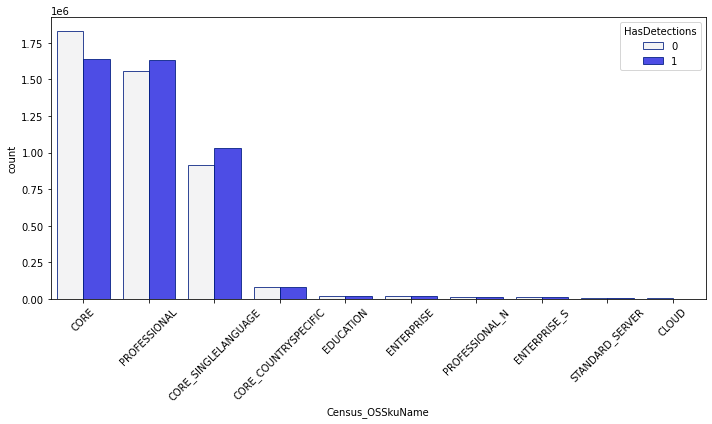

In [112]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Census_OSSkuName',
            hue='HasDetections',
            data=df,
            order=df['Census_OSSkuName'].value_counts().index[:10],
            color='blue',
            edgecolor=sns.color_palette('dark', 1),
            alpha=0.8)
plt.legend(loc=1, title='HasDetections')
plt.xticks(rotation = 45)
plt.tight_layout()

In [113]:
df['Census_OSSkuName'].dtype

CategoricalDtype(categories=['CLOUD', 'CLOUDN', 'CORE', 'CORE_COUNTRYSPECIFIC', 'CORE_N',
                  'CORE_SINGLELANGUAGE', 'DATACENTER_EVALUATION_SERVER',
                  'DATACENTER_SERVER', 'EDUCATION', 'EDUCATION_N',
                  'ENTERPRISE', 'ENTERPRISEG', 'ENTERPRISE_N', 'ENTERPRISE_S',
                  'ENTERPRISE_S_N', 'PROFESSIONAL', 'PROFESSIONAL_N',
                  'PRO_CHINA', 'PRO_FOR_EDUCATION', 'PRO_SINGLE_LANGUAGE',
                  'PRO_WORKSTATION', 'PRO_WORKSTATION_N', 'SB_SOLUTION_SERVER',
                  'SERVERRDSH', 'STANDARD_EVALUATION_SERVER',
                  'STANDARD_SERVER', 'STARTER', 'ULTIMATE', 'UNDEFINED',
                  'UNLICENSED'],
, ordered=False)

In [114]:
df['Census_OSSkuName'].cat.add_categories('Other', inplace=True)
df.loc[(df['Census_OSSkuName'] != 'CORE') & 
       (df['Census_OSSkuName'] != 'PROFESSIONAL') &
       (df['Census_OSSkuName'] != 'CORE_SINGLELANGUAGE') &
       (df['Census_OSSkuName'] != 'CORE_COUNTRYSPECIFIC') &
       (df['Census_OSSkuName'] != 'EDUCATION') &
       (df['Census_OSSkuName'] != 'ENTERPRISE') &
       (df['Census_OSSkuName'] != 'PROFESSIONAL_N') &
       (df['Census_OSSkuName'] != 'PROFESSIONAL_S'),
             'Census_OSSkuName'] = 'Other'
df['Census_OSSkuName'].cat.remove_unused_categories(inplace=True)
df.rename(columns={'Census_OSSkuName':'Census_OSSkuName_encoded'}, inplace=True)
df['Census_OSSkuName_encoded'].value_counts(normalize=True)

CORE                    0.388934
PROFESSIONAL            0.357330
CORE_SINGLELANGUAGE     0.218028
CORE_COUNTRYSPECIFIC    0.018594
Other                   0.005350
EDUCATION               0.004576
ENTERPRISE              0.003991
PROFESSIONAL_N          0.003197
Name: Census_OSSkuName_encoded, dtype: float64

#### SmartScreen

In [115]:
df['SmartScreen'].isnull().sum()

3177010

In [116]:
nans = df['SmartScreen'].isnull()

In [117]:
smart_screen = pd.concat([df['SmartScreen'].value_counts(), 
                            df['SmartScreen'].value_counts(normalize=True) * 100], 
                            axis=1)
smart_screen.columns=['Count', '%']
smart_screen.head(30)


,Count,%
RequireAdmin,4316180,75.136288
ExistsNotSet,1046182,18.211991
Off,186553,3.247524
Warn,135483,2.358495
Prompt,34533,0.601152
Block,22533,0.392256
off,1350,0.023501
On,731,0.012725
&#x02;,416,0.007242
&#x01;,335,0.005832


In [118]:
df.loc[df.SmartScreen == 'requireAdmin', 'SmartScreen'] = 'RequireAdmin'
df.loc[df.SmartScreen == 'requireadmin', 'SmartScreen'] = 'RequireAdmin'
df.loc[df.SmartScreen == 'off', 'SmartScreen'] = 'Off'
df.loc[df.SmartScreen == 'OFF', 'SmartScreen'] = 'Off'
df.loc[df.SmartScreen == 'on', 'SmartScreen'] = 'On'
df.loc[df.SmartScreen == 'warn', 'SmartScreen'] = 'Warn'
df.loc[df.SmartScreen == 'Promt', 'SmartScreen'] = 'Prompt'
df.loc[df.SmartScreen == 'prompt', 'SmartScreen'] = 'Prompt'
df['SmartScreen'].cat.remove_unused_categories(inplace=True)
df.SmartScreen.value_counts() 

RequireAdmin    4316191
ExistsNotSet    1046182
Off              187907
Warn             135484
Prompt            34536
Block             22533
On                  878
&#x02;              416
&#x01;              335
0                     3
&#x03;                1
00000000              1
Enabled               1
Name: SmartScreen, dtype: int64

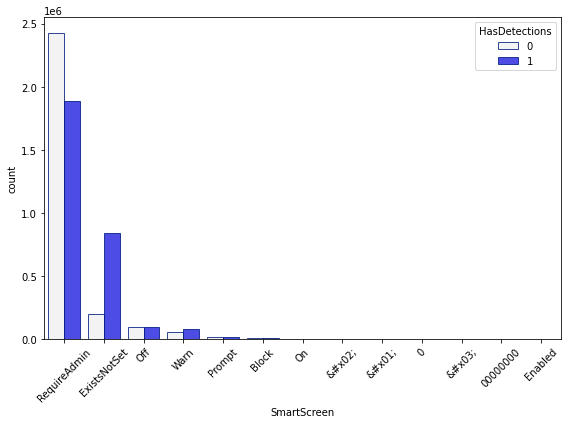

In [119]:
plt.figure(figsize=(8, 6))
sns.countplot(x='SmartScreen',
            hue='HasDetections',
            data=df,
            order=df['SmartScreen'].value_counts().index,
            color='blue',
            edgecolor=sns.color_palette('dark', 1),
            alpha=0.8)
plt.legend(loc=1, title='HasDetections')
plt.xticks(rotation = 45)
plt.tight_layout()

In [120]:
df['SmartScreen'].dtype

CategoricalDtype(categories=['&#x01;', '&#x02;', '&#x03;', '0', '00000000', 'Block',
                  'Enabled', 'ExistsNotSet', 'Off', 'On', 'Prompt',
                  'RequireAdmin', 'Warn'],
, ordered=False)

In [121]:
df['SmartScreen'].cat.add_categories('Other', inplace=True)
df.loc[(df['SmartScreen'] == '&#x02;') | 
       (df['SmartScreen'] == '&#x01;') |
       (df['SmartScreen'] == '&#x03;') |
       (df['SmartScreen'] == '0') |
       (df['SmartScreen'] == 'Enabled') |
       (df['SmartScreen'] == '00000000'),
       'SmartScreen'] = 'Other'
df['SmartScreen'].cat.remove_unused_categories(inplace=True)
df.loc[nans, 'SmartScreen'] = np.nan
df['SmartScreen'] = df['SmartScreen'].astype('category')
df.rename(columns={'SmartScreen':'SmartScreen_encoded'}, inplace=True)
df['SmartScreen_encoded'].value_counts(normalize=True)

RequireAdmin    0.751365
ExistsNotSet    0.182120
Off             0.032711
Warn            0.023585
Prompt          0.006012
Block           0.003923
On              0.000153
Other           0.000132
Name: SmartScreen_encoded, dtype: float64

In [122]:
df['SmartScreen_encoded'].isnull().sum()

3177010

#### Census_MDC2FormFactor

In [123]:
df['Census_MDC2FormFactor'].isnull().sum()


0

In [124]:
census_MDC2 = pd.concat([df['Census_MDC2FormFactor'].value_counts(), 
                            df['Census_MDC2FormFactor'].value_counts(normalize=True) * 100], 
                            axis=1)
census_MDC2.columns=['Count', '%']
census_MDC2.head(30)

,Count,%
Notebook,5723314,64.152083
Desktop,1951086,21.869538
Convertible,405378,4.543844
Detachable,298233,3.342865
AllInOne,292077,3.273863
PCOther,139955,1.568742
LargeTablet,67121,0.752353
SmallTablet,31393,0.351881
SmallServer,8630,0.096733
MediumServer,3385,0.037942


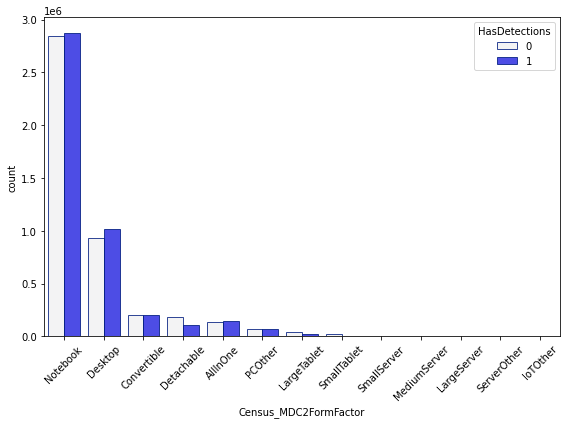

In [125]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Census_MDC2FormFactor',
            hue='HasDetections',
            data=df,
            order=df['Census_MDC2FormFactor'].value_counts().index,
            color='blue',
            edgecolor=sns.color_palette('dark', 1),
            alpha=0.8)
plt.legend(loc=1, title='HasDetections')
plt.xticks(rotation = 45)
plt.tight_layout()


In [126]:
df['Census_MDC2FormFactor'].dtype


CategoricalDtype(categories=['AllInOne', 'Convertible', 'Desktop', 'Detachable',
                  'IoTOther', 'LargeServer', 'LargeTablet', 'MediumServer',
                  'Notebook', 'PCOther', 'ServerOther', 'SmallServer',
                  'SmallTablet'],
, ordered=False)

In [127]:
df['Census_MDC2FormFactor'].cat.add_categories('Other', inplace=True)
df.loc[(df['Census_MDC2FormFactor'] == 'SmallServer') | 
       (df['Census_MDC2FormFactor'] == 'MediumServer') |
       (df['Census_MDC2FormFactor'] == 'LargeServer') |
       (df['Census_MDC2FormFactor'] == 'ServerOther') |
       (df['Census_MDC2FormFactor'] == 'IoTOther'), 
       'Census_MDC2FormFactor'] = 'Other'
df['Census_MDC2FormFactor'].cat.remove_unused_categories(inplace=True)
df.rename(columns={'Census_MDC2FormFactor':'Census_MDC2FormFactor_encoded'}, inplace=True)
df['Census_MDC2FormFactor_encoded'].value_counts(normalize=True)

Notebook       0.641521
Desktop        0.218695
Convertible    0.045438
Detachable     0.033429
AllInOne       0.032739
PCOther        0.015687
LargeTablet    0.007524
SmallTablet    0.003519
Other          0.001448
Name: Census_MDC2FormFactor_encoded, dtype: float64

**UacLuaenable**

In [128]:
uac_luaenable = pd.concat([df['UacLuaenable'].value_counts(), 
                           df['UacLuaenable'].value_counts(normalize=True)*100],
                           axis=1)
uac_luaenable.columns=['Count', '%']
uac_luaenable.head(15)

,Count,%
1.0,8856512,99.392546
0.0,53851,0.604345
48.0,206,0.002312
2.0,30,0.000337
49.0,17,0.000191
6357062.0,13,0.000146
3.0,6,0.000067
5.0,2,0.000022
16777216.0,1,0.000011
255.0,1,0.000011


In [129]:
df['UacLuaenable'].dtype

CategoricalDtype(categories=['0.0', '1.0', '16777216.0', '2.0', '255.0', '3.0', '48.0',
                  '49.0', '5.0', '6357062.0', '7798884.0'],
, ordered=False)

In [130]:
df['UacLuaenable'] = df['UacLuaenable'][df['UacLuaenable'].notnull()].astype('str')
df['UacLuaenable'].unique()

array(['1.0', '0.0', nan, '48.0', '3.0', '2.0', '6357062.0', '49.0',
       '16777216.0', '5.0', '255.0', '7798884.0'], dtype=object)

In [131]:
df['UacLuaenable'] = df['UacLuaenable'].astype('category')
df['UacLuaenable'].cat.add_categories('Other', inplace=True)
df.loc[df['UacLuaenable'] != '1.0', 'UacLuaenable'] = 'Other'
df['UacLuaenable'].cat.remove_unused_categories(inplace=True)
df.rename(columns={'UacLuaenable':'UacLuaenable_encoded'}, inplace=True)
df['UacLuaenable_encoded'].value_counts(normalize=True)

1.0      0.992718
Other    0.007282
Name: UacLuaenable_encoded, dtype: float64

Let's check the OS features 

#### OsBuildLab

In [132]:
os_build_lab = pd.concat([df['OsBuildLab'].value_counts(),
                        df['OsBuildLab'].value_counts(normalize=True) * 100], 
                        axis=1)
os_build_lab.columns=['Count', '%']
os_build_lab.head(20)

,Count,%
17134.1.amd64fre.rs4_release.180410-1804,3658197,41.004479
16299.431.amd64fre.rs3_release_svc_escrow.180502-1908,1252674,14.041137
16299.15.amd64fre.rs3_release.170928-1534,961060,10.772456
15063.0.amd64fre.rs2_release.170317-1834,718033,8.048383
17134.1.x86fre.rs4_release.180410-1804,257074,2.881525
16299.15.x86fre.rs3_release.170928-1534,233449,2.616714
14393.2189.amd64fre.rs1_release.180329-1711,193636,2.170453
10240.17443.amd64fre.th1.170602-2340,171990,1.927824
10586.1176.amd64fre.th2_release_sec.170913-1848,148259,1.661825
15063.0.x86fre.rs2_release.170317-1834,62237,0.697610


OsBuildLab has very high cardinality. It seems many features are generated by extracting substrings from OsBuildLab, e.g. Census_OSBranch, OsBuild, Census_OSArchitecture, OsPlatformSubRelease, etc. Some of these features might be redundant. 

In [133]:
df.loc[:, df.columns.str.contains('OS|Os|os', regex=True)]

,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition_encoded,Census_OSSkuName_encoded,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_OSVersion_extracted,OsVer_encoded
0,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,10.0.17134.165,amd64,rs4_release,17134,165,Professional,PROFESSIONAL,UUPUpgrade,26.0,119,UNKNOWN,17134,10.0
1,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,10.0.17134.1,amd64,rs4_release,17134,1,Professional,PROFESSIONAL,IBSClean,8.0,31,UNKNOWN,17134,10.0
2,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,10.0.17134.165,amd64,rs4_release,17134,165,Core,CORE,UUPUpgrade,7.0,30,FullAuto,17134,10.0
3,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,10.0.17134.228,amd64,rs4_release,17134,228,Professional,PROFESSIONAL,UUPUpgrade,17.0,64,FullAuto,17134,10.0
4,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,10.0.17134.191,amd64,rs4_release,17134,191,Core,CORE,Update,8.0,31,FullAuto,17134,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8921478,10.0.0.0,16299,768,rs3,16299.431.amd64fre.rs3_release_svc_escrow.1805...,10.0.16299.431,amd64,rs3_release_svc_escrow,16299,431,Core,CORE,UUPUpgrade,14.0,49,UNKNOWN,16299,10.0
8921479,10.0.0.0,10586,256,th2,10586.672.x86fre.th2_release_sec.161024-1825,10.0.10586.679,x86,th2_release_sec,10586,679,Professional,PROFESSIONAL,Update,14.0,49,FullAuto,10586,10.0
8921480,10.0.0.0,16299,768,rs3,16299.15.amd64fre.rs3_release.170928-1534,10.0.16299.371,amd64,rs3_release,16299,371,Other,CORE_COUNTRYSPECIFIC,UUPUpgrade,37.0,158,UNKNOWN,16299,10.0
8921481,10.0.0.0,15063,768,rs2,15063.0.amd64fre.rs2_release.170317-1834,10.0.15063.483,amd64,rs2_release,15063,483,Core,CORE,Other,8.0,31,Notify,15063,10.0


Let's extract features from the string in OsBuildLab and compare with other features in the dataset. The objective is to drop all the redundant columns and keep potentially useful features.

In [134]:
temp_df = pd.DataFrame()
temp_df['OsBuildLab'] = df['OsBuildLab']
temp_df['OsBuild'] = temp_df.OsBuildLab.str.split('.').str.get(0)
temp_df['OsPlatformSubRelease'] = temp_df.OsBuildLab.str.split('.').str.get(3).str.split('_').str.get(0)
temp_df['Census_OSArchitecture'] = temp_df.OsBuildLab.str.split('.').str.get(2).str.replace('fre', '')
temp_df['Census_OSBranch'] = temp_df.OsBuildLab.str.split('.').str.get(3)
temp_df.head()

,OsBuildLab,OsBuild,OsPlatformSubRelease,Census_OSArchitecture,Census_OSBranch
0,17134.1.amd64fre.rs4_release.180410-1804,17134,rs4,amd64,rs4_release
1,17134.1.amd64fre.rs4_release.180410-1804,17134,rs4,amd64,rs4_release
2,17134.1.amd64fre.rs4_release.180410-1804,17134,rs4,amd64,rs4_release
3,17134.1.amd64fre.rs4_release.180410-1804,17134,rs4,amd64,rs4_release
4,17134.1.amd64fre.rs4_release.180410-1804,17134,rs4,amd64,rs4_release


In [135]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8921478 entries, 0 to 8921482
Data columns (total 5 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   OsBuildLab             category
 1   OsBuild                object  
 2   OsPlatformSubRelease   object  
 3   Census_OSArchitecture  object  
 4   Census_OSBranch        object  
dtypes: category(1), object(4)
memory usage: 615.4+ MB


In [136]:
df[temp_df.columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8921478 entries, 0 to 8921482
Data columns (total 5 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   OsBuildLab             category
 1   OsBuild                category
 2   OsPlatformSubRelease   category
 3   Census_OSArchitecture  category
 4   Census_OSBranch        category
dtypes: category(5)
memory usage: 377.1 MB


In [137]:
for col in temp_df.columns:
    if col != 'OsBuildLab':
        if col == 'OsBuild':
            print('{}% of the {} entries are different.'.format(round(np.mean(df[col].astype('float') != temp_df[col].astype('float'))*100, 2), col))       
        else:
            print(f'{round(np.mean(df[col] != temp_df[col])*100 ,2)}% of the {col} entries are different.')

0.0% of the OsBuild entries are different.
3.47% of the OsPlatformSubRelease entries are different.
0.18% of the Census_OSArchitecture entries are different.
11.67% of the Census_OSBranch entries are different.


OsBuild is extracted from OsBuildLab. Also, looking at the df containing all OS features, it seems like also Census_OSBuildNumber is redundant and no different than OsBuild.

In [138]:
check_redundant_features = ['Census_OSBuildNumber']
for feat in check_redundant_features:
    print('{}% of the {} entries are different.'
          .format(round(np.mean(df[feat].astype('float') 
                                != df['OsBuild'].astype('float'))*100, 
                        2), feat))

4.99% of the Census_OSBuildNumber entries are different.


In [139]:
df[['OsBuild', 
    'Census_OSBuildNumber', 
    'Census_OSVersion']][df['OsBuild'].astype('float') != df['Census_OSBuildNumber'].astype('float')]

,OsBuild,Census_OSBuildNumber,Census_OSVersion
16,7601,10586,10.0.10586.164
17,16299,17134,10.0.17134.191
20,9600,14393,10.0.14393.0
41,9600,10586,10.0.10586.545
49,9600,10586,10.0.10586.14
...,...,...,...
8921369,17134,16299,10.0.16299.431
8921400,7601,10586,10.0.10586.164
8921442,9600,17134,10.0.17134.112
8921452,9600,10586,10.0.10586.318


Census_OSBuildNumber differs from OsBuild in ~5% of the entries. Let's add it to the drop list.

In [140]:
to_drop.append('Census_OSBuildNumber')

In [141]:
def compare_feature(col_name):
    ''' 
    Reads column name (str). 
    Returns a df summarizing comparing original and 
    extracted features, a list of tuples containing the 
    different element, and the count of different elements
    '''
    df_1 = pd.DataFrame(df[df[col_name] != temp_df[col_name]][['OsBuildLab', col_name]].values, columns=['OsBuildLab', col_name+'1'])
    df_2 = pd.DataFrame(temp_df[df[col_name] != temp_df[col_name]][col_name].values, columns=[col_name+'2'])
    comparison_df = pd.concat([df_1, df_2], axis=1)
    comp_list = list(zip(comparison_df.iloc[:, 1], comparison_df.iloc[:, 2]))

    return comparison_df, comp_list, Counter(comp_list)

In [142]:
comparison_df, comp_list, tuple_counts = compare_feature('OsPlatformSubRelease')

In [143]:
comparison_df.head()

,OsBuildLab,OsPlatformSubRelease1,OsPlatformSubRelease2
0,7601.18409.amd64fre.win7sp1_gdr.140303-2144,windows7,win7sp1
1,9600.19067.x86fre.winblue_ltsb_escrow.180619-2033,windows8.1,winblue
2,9600.19067.amd64fre.winblue_ltsb_escrow.180619...,windows8.1,winblue
3,9600.19125.amd64fre.winblue_ltsb.180812-0703,windows8.1,winblue
4,9600.19000.amd64fre.winblue_ltsb.180410-0600,windows8.1,winblue


In [144]:
tuple_counts

Counter({('windows7', 'win7sp1'): 93308,
         ('windows8.1', 'winblue'): 194497,
         ('prers5', 'rs5'): 15015,
         ('prers5', 'rs'): 5976,
         ('windows7', 'win7'): 581,
         ('rs4', 'rs1'): 12,
         ('rs4', 'rs3'): 2,
         ('rs4', nan): 7,
         ('windows8.1', nan): 9,
         ('rs3', nan): 5,
         ('rs3', 'rs1'): 1,
         ('prers5', 'rs4'): 1,
         ('rs4', 'rs6'): 1,
         ('windows8.1', 'rs4'): 1})

It looks like the values are consistent.

In [145]:
comparison_df, comp_list, tuple_counts = compare_feature('Census_OSArchitecture')
tuple_counts

Counter({('x86', 'amd64'): 7619,
         ('amd64', 'x86'): 8069,
         ('x86', nan): 2,
         ('amd64', nan): 19})

It looks like the 64 and 32 bits are switched occasionally.

In [146]:
comparison_df, comp_list, tuple_counts = compare_feature('Census_OSBranch')
comparison_df

,OsBuildLab,Census_OSBranch1,Census_OSBranch2
0,7601.18409.amd64fre.win7sp1_gdr.140303-2144,th2_release,win7sp1_gdr
1,16299.431.amd64fre.rs3_release_svc_escrow.1805...,rs4_release,rs3_release_svc_escrow
2,9600.19067.x86fre.winblue_ltsb_escrow.180619-2033,rs1_release,winblue_ltsb_escrow
3,10240.17914.amd64fre.th1.180627-1911,th1_st1,th1
4,14393.576.x86fre.rs1_release_inmarket.161208-2252,rs1_release,rs1_release_inmarket
...,...,...,...
1041343,14393.576.amd64fre.rs1_release_inmarket.161208...,rs1_release,rs1_release_inmarket
1041344,9600.19101.amd64fre.winblue_ltsb_escrow.180718...,rs4_release,winblue_ltsb_escrow
1041345,9600.17630.amd64fre.winblue_r7.150109-2022,th2_release,winblue_r7
1041346,10240.17443.amd64fre.th1.170602-2340,th1_st1,th1


In [147]:
tuple_counts

Counter({('th2_release', 'win7sp1_gdr'): 1649,
         ('rs4_release', 'rs3_release_svc_escrow'): 42896,
         ('rs1_release', 'winblue_ltsb_escrow'): 31252,
         ('th1_st1', 'th1'): 179636,
         ('rs1_release', 'rs1_release_inmarket'): 105908,
         ('th2_release', 'winblue_ltsb_escrow'): 72699,
         ('th2_release', 'winblue_ltsb'): 32633,
         ('th2_release', 'th2_release_sec'): 71601,
         ('rs3_release_svc_escrow', 'rs3_release'): 12335,
         ('rs4_release', 'rs3_release'): 46023,
         ('th2_release', 'th2_release_inmarket'): 4355,
         ('rs1_release', 'rs1_release_sec'): 36354,
         ('rs1_release', 'rs1_release_1'): 41670,
         ('th2_release', 'win7sp1_ldr'): 36923,
         ('th2_release', 'win7sp1_ldr_escrow'): 27165,
         ('rs3_release', 'rs3_release_svc_escrow'): 35884,
         ('rs3_release', 'rs3_release_svc'): 45527,
         ('rs4_release', 'rs2_release'): 4645,
         ('th1', 'th1_st1'): 3435,
         ('rs1_release', 

There are more inconsistencies here, I will extract **branch release** from **OsBuildLab** for further processing. The other features extracted from **OsBuildLab** are actually already present in the dataset. Hence, after extracting the **branch release**, I can drop **OsBuildLab**.

In [148]:
df['Census_OSBranch_release_extracted'] = df.OsBuildLab.str.split('.').str.get(3)
df['Census_OSBranch_release_extracted'] = df['Census_OSBranch_release_extracted'].astype('category')
df['Census_OSBranch_release_extracted']

0                     rs4_release
1                     rs4_release
2                     rs4_release
3                     rs4_release
4                     rs4_release
                    ...          
8921478    rs3_release_svc_escrow
8921479           th2_release_sec
8921480               rs3_release
8921481               rs2_release
8921482               rs4_release
Name: Census_OSBranch_release_extracted, Length: 8921478, dtype: category
Categories (51, object): ['rs1_release', 'rs1_release_1', 'rs1_release_d', 'rs1_release_inmarket', ..., 'winblue_r7', 'winblue_r8', 'winblue_r9', 'winblue_rtm']

In [149]:
to_drop.append('OsBuildLab')

There is still a couple possible redundancies in the data.

**Census_OSBranch** and **OsPlatformSubRelease**  likely carry same info:

In [150]:
df[df.Census_OSBranch.astype('object') != df.OsPlatformSubRelease.astype('object')][['Census_OSBranch', 'OsPlatformSubRelease']]

,Census_OSBranch,OsPlatformSubRelease
0,rs4_release,rs4
1,rs4_release,rs4
2,rs4_release,rs4
3,rs4_release,rs4
4,rs4_release,rs4
...,...,...
8921478,rs3_release_svc_escrow,rs3
8921479,th2_release_sec,th2
8921480,rs3_release,rs3
8921481,rs2_release,rs2


In [151]:
np.mean(df.Census_OSBranch.astype('object').str.split('_').str.get(0) != df.OsPlatformSubRelease.astype('object'))

0.05193735836147329

In [152]:
df[['Census_OSBranch', 'OsPlatformSubRelease']][df.Census_OSBranch.astype('object').str.split('_').str.get(0) != df.OsPlatformSubRelease.astype('object')]

,Census_OSBranch,OsPlatformSubRelease
16,th2_release,windows7
17,rs4_release,rs3
20,rs1_release,windows8.1
41,th2_release,windows8.1
49,th2_release,windows8.1
...,...,...
8921400,th2_release,windows7
8921442,rs4_release,windows8.1
8921452,th2_release,windows8.1
8921457,rs5_release,prers5


In [153]:
to_drop.append('Census_OSBranch')

Let's encode the remaining features:


**OsBuild**

In [154]:
df['OsBuild'].isnull().sum()

0

In [155]:
os_build = pd.concat([df['OsBuild'].value_counts(), 
                      df['OsBuild'].value_counts(normalize=True)*100], 
                      axis=1)
os_build.columns=['Count', '%']
os_build.head(10)

,Count,%
17134,3915519,43.888681
16299,2503681,28.063523
15063,780270,8.745972
14393,730818,8.191670
10586,411606,4.613653
10240,270191,3.028545
9600,194507,2.180210
7601,93306,1.045858
17692,3184,0.035689
17738,2478,0.027776


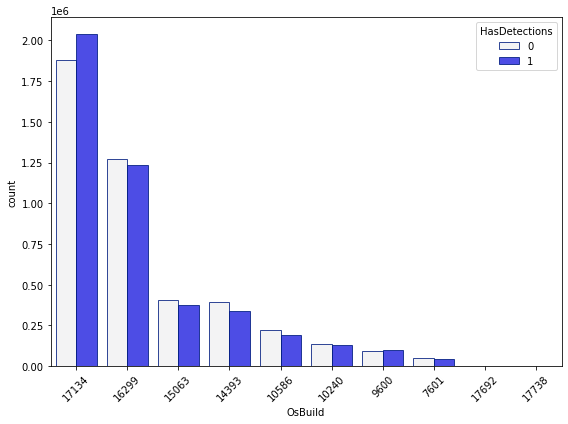

In [156]:
plt.figure(figsize=(8, 6))
sns.countplot(x='OsBuild',
            hue='HasDetections',
            data=df,
            order=df['OsBuild'].value_counts().index[:10],
            color='blue',
            edgecolor=sns.color_palette('dark', 1),
            alpha=0.8)
plt.legend(loc=1, title='HasDetections')
plt.xticks(rotation = 45)
plt.tight_layout()

In [157]:
np.mean(df['OsBuild'].astype('float') != df['Census_OSVersion_extracted'].astype('float'))*100

4.993522373759146

In [158]:
to_drop.append('Census_OSVersion_extracted')

In [159]:
df['OsBuild'].dtype

CategoricalDtype(categories=['10240', '10586', '14393', '15063', '16299', '17133',
                  '17134', '17604', '17618', '17623', '17627', '17634',
                  '17639', '17643', '17650', '17655', '17661', '17666',
                  '17672', '17677', '17682', '17686', '17689', '17692',
                  '17694', '17704', '17711', '17713', '17718', '17723',
                  '17725', '17728', '17730', '17733', '17734', '17735',
                  '17738', '17740', '17741', '17744', '17746', '17747',
                  '17749', '17750', '17751', '17752', '17753', '17754',
                  '17755', '17756', '17757', '17758', '17759', '17760',
                  '17761', '17763', '18201', '18204', '18214', '18219',
                  '18224', '18226', '18227', '18230', '18233', '18234',
                  '18236', '18237', '18238', '18240', '18241', '18242',
                  '18244', '7600', '7601', '9600'],
, ordered=False)

In [160]:
df['OsBuild'] = df['OsBuild'][df['OsBuild'].notnull()].astype('str')
df['OsBuild'].unique()

array(['17134', '14393', '16299', '7601', '9600', '10240', '15063',
       '10586', '17744', '17692', '17738', '17751', '17755', '17730',
       '17733', '17746', '17735', '17754', '17741', '17713', '17740',
       '17672', '17758', '17763', '7600', '17666', '17677', '17686',
       '17747', '17760', '17759', '17682', '17761', '17704', '17661',
       '17643', '18234', '17618', '18204', '17639', '17634', '17728',
       '18237', '18242', '17133', '17723', '17650', '17711', '18219',
       '18240', '17627', '17655', '18214', '18201', '17604', '18224',
       '18241', '17689', '17718', '17753', '18227', '18238', '17725',
       '17694', '17757', '18233', '17623', '17756', '17749', '17734',
       '17752', '18226', '18230', '18244', '18236', '17750'], dtype=object)

In [161]:
df['OsBuild'] = df['OsBuild'].astype('category')
df['OsBuild'].cat.add_categories('Other', inplace=True)
df.loc[(df['OsBuild'] != '17134') & 
       (df['OsBuild'] != '16299') &
       (df['OsBuild'] != '15063') &
       (df['OsBuild'] != '14393') &
       (df['OsBuild'] != '10586') &
       (df['OsBuild'] != '10240') &
       (df['OsBuild'] != '9600') &
       (df['OsBuild'] != '7601'),
       'OsBuild'] = 'Other'
df['OsBuild'].cat.remove_unused_categories(inplace=True)
df.rename(columns={'OsBuild':'OsBuild_encoded'}, inplace=True)
df['OsBuild_encoded'].value_counts(normalize=True)

17134    0.438887
16299    0.280635
15063    0.087460
14393    0.081917
10586    0.046137
10240    0.030285
9600     0.021802
7601     0.010459
Other    0.002419
Name: OsBuild_encoded, dtype: float64

**OsSuite**

In [162]:
df['OsSuite'].isnull().sum()

0

In [163]:
os_suite = pd.concat([df['OsSuite'].value_counts(), 
                      df['OsSuite'].value_counts(normalize=True)*100], 
                      axis=1)
os_suite.columns=['Count', '%']
os_suite.head(10)

,Count,%
768,5560657,62.328876
256,3346250,37.507799
272,12092,0.135538
400,793,0.008889
16,731,0.008194
305,662,0.007420
784,198,0.002219
274,39,0.000437
144,34,0.000381
49,17,0.000191


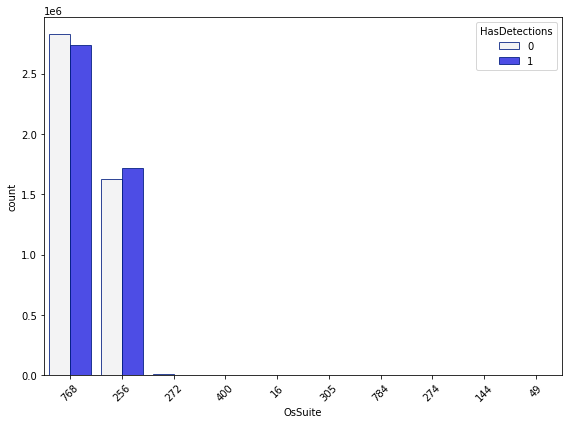

In [164]:
plt.figure(figsize=(8, 6))
sns.countplot(x='OsSuite',
            hue='HasDetections',
            data=df,
            order=df['OsSuite'].value_counts().index[:10],
            color='blue',
            edgecolor=sns.color_palette('dark', 1),
            alpha=0.8)
plt.legend(loc=1, title='HasDetections')
plt.xticks(rotation = 45)
plt.tight_layout()

In [165]:
df['OsSuite'].dtype

CategoricalDtype(categories=['144', '16', '18', '256', '272', '274', '305', '307', '400',
                  '402', '49', '528', '768', '784'],
, ordered=False)

In [166]:
df['OsSuite'] = df['OsSuite'][df['OsSuite'].notnull()].astype('str')
df['OsSuite'].unique()

array(['256', '768', '272', '16', '400', '784', '305', '274', '49', '144',
       '402', '528', '307', '18'], dtype=object)

In [167]:
df['OsSuite'] = df['OsSuite'].astype('category')
df['OsSuite'].cat.add_categories('Other', inplace=True)
df.loc[(df['OsSuite'] != '768') & 
       (df['OsSuite'] != '256'), 
       'OsSuite'] = 'Other'
df['OsSuite'].cat.remove_unused_categories(inplace=True)
df.rename(columns={'OsSuite':'OsSuite_encoded'}, inplace=True)
df['OsSuite_encoded'].value_counts(normalize=True)

768      0.623289
256      0.375078
Other    0.001633
Name: OsSuite_encoded, dtype: float64

**Census_OSBuildRevision**

In [168]:
census_os_build_rev = pd.concat([df['Census_OSBuildRevision'].value_counts(),
                                 df['Census_OSBuildRevision'].value_counts(normalize=True)*100],
                                 axis=1)
census_os_build_rev.columns=['Count', '%']
census_os_build_rev.head(30)

,Count,%
228,1413633,15.845278
165,899712,10.084786
431,546548,6.126205
285,470278,5.271301
547,346853,3.887842
112,346488,3.883751
371,325267,3.645887
191,228255,2.558489
2189,223774,2.508262
611,216776,2.429822


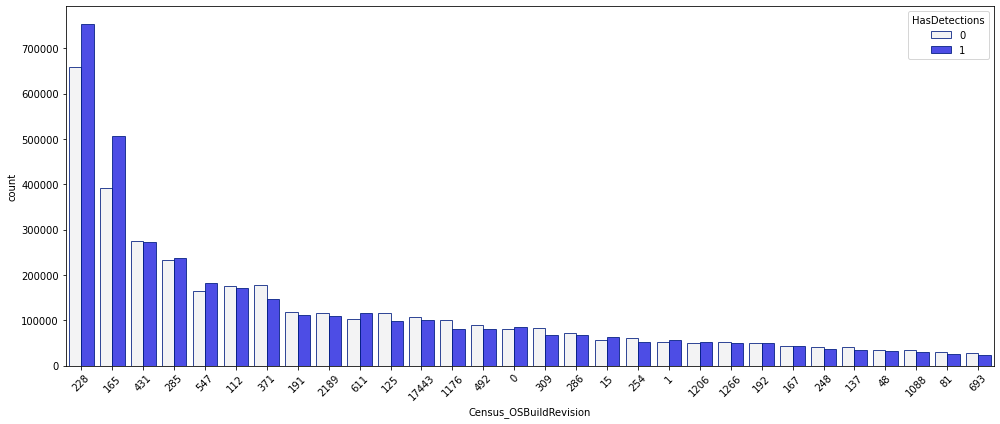

In [169]:
plt.figure(figsize=(14, 6))
sns.countplot(x='Census_OSBuildRevision',
            hue='HasDetections',
            data=df,
            order=df['Census_OSBuildRevision'].value_counts().index[:30],
            color='blue',
            edgecolor=sns.color_palette('dark', 1),
            alpha=0.8)
plt.legend(loc=1, title='HasDetections')
plt.xticks(rotation = 45)
plt.tight_layout()

In [170]:
df['Census_OSBuildRevision'].dtype # need to encode it or treat as IDs

CategoricalDtype(categories=['0', '1', '10', '1000', '1001', '1002', '1003', '1004',
                  '1005', '1007',
                  ...
                  '91', '916', '936', '953', '962', '966', '969', '970', '98',
                  '994'],
, ordered=False)

**Census_OSBranch_release_extracted**

In [171]:
census_os_release = pd.concat([df['Census_OSBranch_release_extracted'].value_counts(),
                               df['Census_OSBranch_release_extracted'].value_counts(normalize=True)*100],
                               axis=1)
census_os_release.columns=['Count', '%']
census_os_release.head(30)

,Count,%
rs4_release,3915504,43.888616
rs3_release_svc_escrow,1252730,14.041765
rs3_release,1194585,13.390021
rs2_release,780270,8.745993
rs1_release,535786,6.005589
th2_release_sec,280199,3.140731
th1,252031,2.824998
winblue_ltsb_escrow,136744,1.532754
th2_release,126857,1.421931
rs1_release_inmarket,107885,1.209276


In [172]:
df['Census_OSBranch_release_extracted'] = df['Census_OSBranch_release_extracted'].astype('object')
df.loc[df['Census_OSBranch_release_extracted'].str.contains('rs1', na=False, regex=False), 'Census_OSBranch_release_extracted'] = 'rs1_release'
df.loc[df['Census_OSBranch_release_extracted'].str.contains('rs2', na=False, regex=False), 'Census_OSBranch_release_extracted'] = 'rs2_release'
df.loc[df['Census_OSBranch_release_extracted'].str.contains('rs3', na=False, regex=False), 'Census_OSBranch_release_extracted'] = 'rs3_release'
df.loc[df['Census_OSBranch_release_extracted'].str.contains('rs4', na=False, regex=False), 'Census_OSBranch_release_extracted'] = 'rs4_release'
df.loc[df['Census_OSBranch_release_extracted'].str.contains('rs5', na=False, regex=False), 'Census_OSBranch_release_extracted'] = 'rs5_release'
df.loc[df['Census_OSBranch_release_extracted'].str.contains('win', na=False, regex=False), 'Census_OSBranch_release_extracted'] = 'win'
df.loc[df['Census_OSBranch_release_extracted'].str.contains('th2', na=False, regex=False), 'Census_OSBranch_release_extracted'] = 'th'
df.loc[df['Census_OSBranch_release_extracted'].str.contains('th1', na=False, regex=False), 'Census_OSBranch_release_extracted'] = 'th'
df.loc[df['Census_OSBranch_release_extracted'].str.contains('rs_pre', na=False, regex=False), 'Census_OSBranch_release_extracted'] = 'rs_prerelease'
df['Census_OSBranch_release_extracted'].value_counts(normalize=True)

rs4_release                  4.388862e-01
rs3_release                  2.806354e-01
rs2_release                  8.745993e-02
rs1_release                  8.191835e-02
th                           7.642216e-02
win                          3.232499e-02
rs5_release                  1.683021e-03
rs_prerelease                6.691732e-04
rs_xbox                      2.241786e-07
rs_onecore_base_cobalt       1.120893e-07
rs_onecore_sigma_grfx_dev    1.120893e-07
rs6_prerelease               1.120893e-07
rs_shell                     1.120893e-07
rs_onecore_stack_per1        1.120893e-07
Name: Census_OSBranch_release_extracted, dtype: float64

In [173]:
other_os_branch = ~df['Census_OSBranch_release_extracted'].isin(['rs4_release',
                                                                 'rs3_release',
                                                                 'rs2_release',
                                                                 'rs1_release',
                                                                 'th'
                                                                ])

df.loc[other_os_branch, 'Census_OSBranch_release_extracted'] = 'Other'
df.rename(columns={'Census_OSBranch_release_extracted':'Census_OSBranch_release_encoded'}, inplace=True)


In [174]:
df['Census_OSBranch_release_encoded'] = df['Census_OSBranch_release_encoded'].astype('category')
df['Census_OSBranch_release_encoded'].value_counts(normalize=True)

rs4_release    0.438885
rs3_release    0.280635
rs2_release    0.087460
rs1_release    0.081918
th             0.076422
Other          0.034680
Name: Census_OSBranch_release_encoded, dtype: float64

In [175]:
df['Census_OSBranch_release_encoded'].dtype

CategoricalDtype(categories=['Other', 'rs1_release', 'rs2_release', 'rs3_release',
                  'rs4_release', 'th'],
, ordered=False)

All features with high cardinality have been reduced to 3-10 levels. Let's see what features we will drop: 

In [176]:
to_drop

['AvSigVersion',
 'Census_OSVersion',
 'AppVersion',
 'EngineVersion',
 'OsVer',
 'Census_OSBuildNumber',
 'OsBuildLab',
 'Census_OSBranch',
 'Census_OSVersion_extracted']

In [177]:
df = df.drop(to_drop, axis=1)
df.shape

(8921478, 71)

#### Summary of columns by type

In [179]:
cat_col = df.select_dtypes('category').columns.tolist()
binary_col = df.select_dtypes('Int64').columns.tolist()
num_col = [col for col in df.columns if col not in cat_col if col not in binary_col]

In [180]:
cat_col 

['ProductName',
 'RtpStateBitfield',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AVProductsEnabled',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'Platform',
 'Processor',
 'OsBuild_encoded',
 'OsSuite_encoded',
 'OsPlatformSubRelease',
 'SkuEdition',
 'IsProtected',
 'IeVerIdentifier',
 'SmartScreen_encoded',
 'UacLuaenable_encoded',
 'Census_MDC2FormFactor_encoded',
 'Census_DeviceFamily',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_PrimaryDiskTypeName',
 'Census_ChassisTypeName_encoded',
 'Census_PowerPlatformRoleName',
 'Census_InternalBatteryNumberOfCharges',
 'Census_OSArchitecture',
 'Census_OSBuildRevision',
 'Census_OSEdition_encoded',
 'Census_OSSkuName_encoded',
 'Census_OSInstallTypeName',
 'Census_OSInstallLanguageIdentifier',
 'Census_OSUILocaleIdentifier',
 'Census_OSWUAutoUpdateOp

In [181]:
binary_col 

['IsSxsPassiveMode',
 'HasTpm',
 'AutoSampleOptIn',
 'SMode',
 'Firewall',
 'Census_HasOpticalDiskDrive',
 'Census_IsPortableOperatingSystem',
 'Census_IsFlightsDisabled',
 'Census_IsSecureBootEnabled',
 'Census_IsVirtualDevice',
 'Census_IsTouchEnabled',
 'Census_IsPenCapable',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'Wdft_IsGamer',
 'HasDetections']

In [182]:
num_col

['Census_ProcessorCoreCount',
 'Census_PrimaryDiskTotalCapacity',
 'Census_SystemVolumeTotalCapacity',
 'Census_TotalPhysicalRAM',
 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
 'Census_InternalPrimaryDisplayResolutionHorizontal',
 'Census_InternalPrimaryDisplayResolutionVertical']

Some of the categorical columns are IDs and have high cardinality. Reducing cardinality here makes less sense, as there is no obvious way. Thus, I'll use mean encoding or some other technique. These columns are:

In [183]:
id_col = [col for col in df.columns if 'Identifier' in col]
id_col

['AVProductStatesIdentifier',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'IeVerIdentifier',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_OSInstallLanguageIdentifier',
 'Census_OSUILocaleIdentifier',
 'Census_FirmwareManufacturerIdentifier',
 'Census_FirmwareVersionIdentifier',
 'Wdft_RegionIdentifier']

In [184]:
print(f'After data cleaning we have {len(cat_col)+len(binary_col)} categorical columns, of which {len(id_col)} are IDs and {len(binary_col)} are binary, and {len(num_col)} numerical (discrete values), for a total of {len(cat_col) + len(num_col) + len(binary_col)} columns, including the target variable.')

After data cleaning we have 64 categorical columns, of which 16 are IDs and 15 are binary, and 7 numerical (discrete values), for a total of 71 columns, including the target variable.


In [185]:
df.to_pickle('../data/interim/train_clean.pickle')

#### Summary:
- The dataset has initially 8921483 and 83 features, including the target variable "HasDetections";
- Features include numerical and categorical (strings, numerical encoding, and binary) features;
- The target variable is balanced and has no missing values;
- The columns which contain more than 40% null values have been dropped, these are:
    - 'DefaultBrowsersIdentifier',
    - 'PuaMode',
    - 'Census_ProcessorClass',
    - 'Census_InternalBatteryType',
    - 'Census_IsFlightingInternal',
    - 'Census_ThresholdOptIn',
    - 'Census_IsWIMBootEnabled'
- There are no duplicated in the dataset;
- The 'MachineIdentifier' column has been dropped;
- The number of leves of the categorical features with high cardinality has been reduced;
- Categorical columns containing numerical IDs should be treated with a different encoding, e.g. mean encoding, this will be performed in the feature engineering notebook later;
- Encoding of 'IsProtected' was changed and relabeled as 'IsProtected_encoded' ;
- Spelling typos and inconsistencies were fixed in the categorical variables 'Census_OSEdition' and 'SmartScreen', e.g. categories labeled as "OFF", "Off", "off", etc.;
- Features related to the OS were investigated, those redundant have been dropped, e.g. 'OsBuildLab' and 'Census_OSBuildNumber';
- Binary features types were set to 'Int64' to preserve the nan's (python default is float64. Int64 is convenient to separate binary variables from continuous/ordinal numerical variables);
- Binary 'IsBeta' was dropped as it has no predictive power;
- Categorical features encoded with numbers were changed to category dtype;
- Obvious outliers have been eliminated from numerical columns, although some extreme values still exist and will be evaluated in the EAD;
- The cleaned data set has 8921478 and 71 columns of which 64 are categorical and 7 numerical discrete. Of the categorical variables 15 are binary and 16 are IDs;
- The dataset includes rows with missing values, these will be taken care of by inputation in the preprocessing and feature engineering phase.